# WDBC — Do EDA à Produção: Seleção, Validação Cruzada e Exportação do Pipeline

# ✅ Resumo executivo — escolha do modelo

**Painel de variáveis:** `MoreStable12` (12 atributos estáveis, baixa redundância).
**Métrica principal:** **Recall (Maligno = 1)**, com *ROC-AUC* e *AP (PR-AUC)* como métricas de robustez.
**Validação:** CV estratificada e teste *hold-out* estratificado; ajuste de limiar por **OOF** apenas para checar ganhos.

### Resultado no **TESTE** (gráficos e métricas detalhados mais abaixo)

* **LR_L2**

  * **ROC-AUC ≈ 0.9983 | AP ≈ 0.9975 | Recall ≈ 0.976**
  * Matrizes @0.50 e @OOF≈0.54 **quase idênticas** (≈98% malignos capturados; ≈99% benignos corretos).
  * Conclusão: **bem calibrado em 0.50**; OOF não trouxe ganho material.

* **XGB**

  * **ROC-AUC ≈ 0.9967 | AP ≈ 0.9954 | Recall ≈ 0.952** com **threshold 0.50** (bate a meta).
  * Em **OOF≈0.53** o Recall cai para ≈0.93 (mais conservador sem benefício relevante).

> Referência: **RF** ficou abaixo da meta de Recall; **LR_EN** mostrou **instabilidade** entre reexecuções.

### 📌 Decisão

* **Modelo escolhido:** **Regressão Logística L2 (LR_L2)** com **threshold = 0.50**.
  Motivos: **maior Recall** no teste, métricas globais **de topo**, **estabilidade** e **simplicidade/interpretabilidade**.
* **Plano B:** **XGB** @0.50 (atinge Recall ≥ 0.95, mas fica abaixo do LR_L2).

**Observação de reprodutibilidade:** números dependem do *seed* e do *split* estratificado usados; as conclusões foram verificadas também por **análise gráfica** (matriz de confusão, **curvas ROC** e **Precision–Recall**) — ver seção “Avaliação Gráfica”.

# 🧪 Breast Cancer Wisconsin (Diagnostic) — EDA, Seleção de Variáveis, Validação e Exportação

Este notebook documenta o processo completo de construção e entrega de um modelo preditivo para o dataset **Breast Cancer Wisconsin (Diagnostic)**. O fluxo abrange desde o **carregamento/checagens iniciais**, passa por **seleção final de variáveis**, **validação cruzada**, **ajuste de limiar por OOF** (para Recall da classe Maligno) e culmina na **escolha do modelo** e **exportação do pipeline** para uso na API.

Cobrimos: leitura de `data/wdbc.csv` (com *fallback* via `sklearn`), EDA objetiva com resumos (`skim`) e **PCA interpretativo** (sem projeto para redução), seleção de preditores até chegar ao conjunto **MoreStable12** (estável e com baixa redundância), *tuning* em **duas etapas** (*Random Search* seguido de *Grid Search* focal) com **CV estratificada**, e **análise gráfica** das previsões (*matriz de confusão*, **curvas ROC** e **Precision–Recall** com isolinhas de F1 e marcação de limiar).

#### 📁 **Fonte de Dados e Utilitários**

A base utilizada é `data/wdbc.csv` (gerada via `sklearn` se ausente; utilitário em `src/data/make_wdbc_dataset.py`).

Scripts auxiliares em `src/`:

* `src/eda/skim.py` — resumos estatísticos.
* `src/eda/pca_report.py` — **PCA**: scree, biplot, círculo de correlações, contribuições/cos².
* `src/plots/metrics.py` — **avaliação/plots**:

  * `evaluate_at_threshold` (métricas a um limiar),
  * `plot_confusion_matrix`, `plot_roc_curve`, `plot_pr_curve` (usados nos gráficos dos finalistas).

#### 🔧 **Decisões-chave**

**Variável-alvo (`diagnosis`)**

* **1 = Maligno** (classe positiva) • **0 = Benigno**.

**Métrica principal**

* **Recall (Maligno)** — prioriza minimizar falsos negativos.
* Complementares: **ROC-AUC**, **AP (PR-AUC)** e **F1**.

**Seleção final de atributos — *MoreStable12***
Fizemos **seleção de variáveis** (não redução por projeção), guiada por:

1. **Estabilidade** em seletores *embedded* (LR-L1/EN, RF, XGB);
2. **Baixa redundância** via **poda por correlação (Spearman) ≤ 0,90**, preservando a mais informativa por grupo;
3. Evidências do **PCA** (contribuições/cos²) como apoio **interpretativo**.

Painel fixo (**MoreStable12**):

```python
[
  "worst_concavity", "worst_area", "worst_texture", "worst_smoothness",
  "mean_concave_points", "area_error", "mean_compactness", "compactness_error",
  "symmetry_error", "worst_symmetry", "texture_error", "concave_points_error",
]
```

**Modelos (em Pipelines scikit-learn)**
Todos os modelos rodam em **pipelines**, garantindo o mesmo *preprocess* no treino/validação:

* **LR L2** — `SimpleImputer(median)` → `PowerTransformer(Yeo-Johnson)` → `StandardScaler`.
* **LR ElasticNet** — mesmo *pre* da LR L2 (combina L1+L2; útil com colinearidade).
* **Random Forest** — `SimpleImputer(median)` (árvores dispensam escala).
* **XGBoost** — `SimpleImputer(median)` + `scale_pos_weight = neg/pos` para desbalanceamento.

#### 🛡️ **Guard-rails (critérios de segurança)**

Para simplificar sem perder confiabilidade clínica, adotamos limites vs. modelo completo:

* **ΔRecall ≤ 0,02** (classe Maligno): acima disso, o aumento de falsos negativos torna-se clinicamente indesejável.
* **ΔAUC ≤ 0,01**: perdas maiores indicam deterioração do ranking global de risco.

Além disso, ajustamos o **limiar por OOF** (probabilidades fora da amostra na CV) visando **Recall-alvo** (ex.: ≥ 0,95) e validamos com **análise gráfica** (CM, **ROC**, **PR**) implementada em `src/plots/metrics.py`.


## 🧭 Roteiro

**Já realizado**
1. **Importação e checagens** (shape, dtypes, balanceamento da classe)
2. **Resumos**: `skim_numeric`/`skim_categorical`
3. **PCA interpretativo**: scree, PC1×PC2, círculo de correlações, contribuições
4. **Ranking supervisionado**: |corr(y,x)|, **Mutual Information**, contribuições/cos² (PCA)
5. **Poda por correlação** (Spearman |ρ|≥0,90) e **seletores embedded** (LR L1/EN, RF, XGB) com CV
6. **Conciliação & fixação do painel**: **FINAL_FEATURES (12)**  
7. **Comparação em CV (5 folds)**: *Full* × *FinalSelected16* × **MoreStable12** → **MoreStable12 escolhido**
8. **Reavaliar** os 4 modelos **apenas** com `FINAL_FEATURES` (CV 5 folds) 
9. **Ajustar limiar** visando Recall-alvo (reportar precisão/AP)

**Próximos passos**
- **Exportar o pipeline/modelo final** (joblib/pkl) e **documentar** no README + atualizar o **schema da API** (entrada com 12 variáveis)


In [1]:
from pathlib import Path
import sys

def add_project_root(max_up=3, marker='src'):
    p = Path().resolve()
    for _ in range(max_up + 1):
        if (p / marker).exists():
            sys.path.insert(0, str(p))
            return p
        p = p.parent
    raise RuntimeError(f"Não encontrei a pasta '{marker}' nos níveis acima.")

ROOT = add_project_root()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Configurar o tamanho padrão das figuras
plt.rcParams['figure.figsize'] = (12, 6)  # Largura 12, altura 6 (em polegadas)
plt.rcParams['figure.dpi'] = 100          # Resolução


from typing import Optional
try:
    from src.eda.skim import skim_numeric, skim_categorical
    SKIM_OK = True
except Exception as e:
    SKIM_OK = False
    print('Aviso: não foi possível importar skim_numeric/skim_categorical. Erro:', e)
    print('Verifique se existem src/eda/skim.py e __init__.py nos diretórios src/ e src/eda/.')

In [3]:
# Importa a função diretamente
from src.data.make_wdbc_dataset import build_wdbc

# Define o caminho para o arquivo de dados
DATA_PATH = ROOT / "data" / "wdbc.csv"

# Garante que o diretório 'data' exista
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# Verifica se o arquivo já existe
if not DATA_PATH.exists():
    print(f"Arquivo não encontrado em {DATA_PATH}. Gerando via função build_wdbc...")
    try:
        # Chama a função diretamente
        build_wdbc(DATA_PATH)
        print(f"Arquivo gerado e salvo em {DATA_PATH}")
    except Exception as e:
        print("Falha ao rodar o módulo CLI; gerando via sklearn. Erro:", e)
        from sklearn.datasets import load_breast_cancer
        cancer = load_breast_cancer()
        df_tmp = pd.DataFrame(
            cancer["data"],
            columns=[c.replace(" ", "_") for c in cancer["feature_names"]]
        )
        target = pd.Categorical.from_codes(cancer["target"], cancer["target_names"])
        target = target.rename_categories({"malignant": "Maligno", "benign": "Benigno"})
        df_tmp["diagnosis"] = target.astype(str)
        df_tmp.to_csv(DATA_PATH, index=False)
        print("Gerado e salvo em", DATA_PATH)

# Se chegou até aqui, o arquivo deve existir. Carrega o DataFrame.
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (569, 31)


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,Maligno
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,Maligno
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,Maligno
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,Maligno
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,Maligno


## ⚖️ Balanceamento da variável-alvo (`diagnosis`)

diagnosis
Benigno    357
Maligno    212
Name: count, dtype: int64


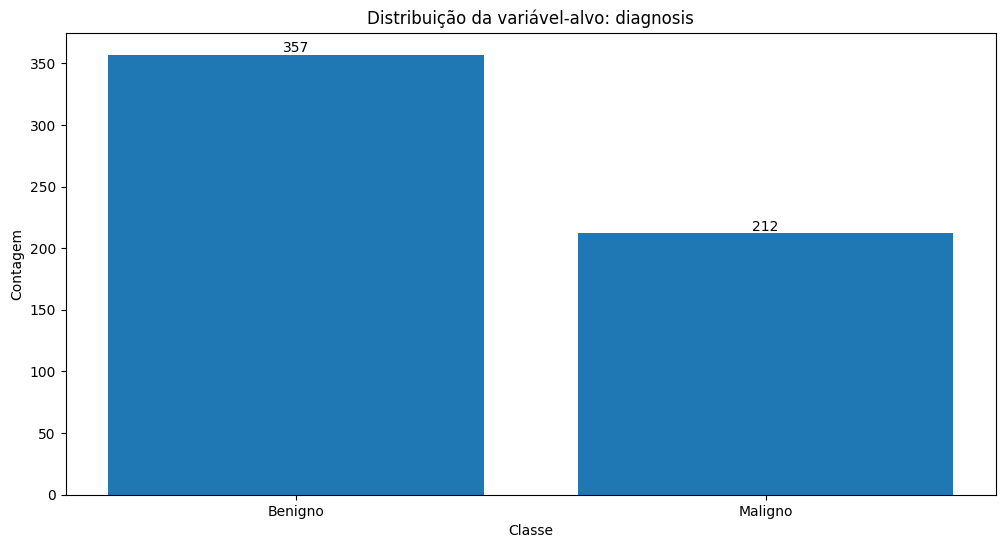

In [4]:
if 'diagnosis' in df.columns:
    vc = df['diagnosis'].value_counts(dropna=False)
    print(vc)
    fig = plt.figure()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title('Distribuição da variável-alvo: diagnosis')
    plt.xlabel('Classe')
    plt.ylabel('Contagem')
    for i, v in enumerate(vc.values):
        plt.text(i, v, str(v), ha='center', va='bottom')
    plt.show()
else:
    print('Coluna diagnosis não encontrada.')

In [5]:
skim_cat = skim_categorical(df)
print(skim_cat.to_string(index=False))

 variable  miss  ordered  n_unique           top_counts
diagnosis     0    False         2 Beni: 357, Mali: 212


## 🔎 Resumo estatístico das variáveis numéricas

In [6]:
skim_num = skim_numeric(df)
print(skim_num.to_string(index=False))

               variable  miss  p_zeros  unique    mean      sd    CV      p0     p25     p50      p75     p100     IQR  hist  skew   kurt
            mean_radius     0   0.0000     456  14.127   3.524 0.249   6.981  11.700  13.370   15.780   28.110   4.080 ▃█▃▂▁ 0.940  0.828
           mean_texture     0   0.0000     479  19.290   4.301 0.223   9.710  16.170  18.840   21.800   39.280   5.630 ▃█▄▁▁ 0.649  0.741
         mean_perimeter     0   0.0000     522  91.969  24.299 0.264  43.790  75.170  86.240  104.100  188.500  28.930 ▃█▃▁▁ 0.988  0.953
              mean_area     0   0.0000     539 654.889 351.914 0.537 143.500 420.300 551.100  782.700 2501.000 362.400 █▄▂▁▁ 1.641  3.610
        mean_smoothness     0   0.0000     474   0.096   0.014 0.146   0.053   0.086   0.096    0.105    0.163   0.019 ▁█▇▁▁ 0.455  0.838
       mean_compactness     0   0.0000     537   0.104   0.053 0.506   0.019   0.065   0.093    0.130    0.345   0.065 █▇▃▁▁ 1.187  1.625
         mean_concavity     0   0.

## 🔗 Correlações (numéricas)

In [7]:

# Correlação de Spearman
df_corr = df.drop(columns=["diagnosis"])
corr = df_corr.corr(numeric_only=True, method="spearman").abs()

# Pegar só metade superior da matriz e listar top pares
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
top_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .reset_index()
         .rename(columns={"level_0":"feat1","level_1":"feat2",0:"abs_corr"})
)

print(top_pairs.head(20))


                  feat1                 feat2  abs_corr
0           mean_radius             mean_area  0.999602
1          worst_radius            worst_area  0.998891
2           mean_radius        mean_perimeter  0.997802
3        mean_perimeter             mean_area  0.997068
4          worst_radius       worst_perimeter  0.993548
5       worst_perimeter            worst_area  0.992433
6        mean_perimeter          worst_radius  0.981244
7        mean_perimeter            worst_area  0.980864
8             mean_area            worst_area  0.980264
9             mean_area          worst_radius  0.979258
10       mean_perimeter       worst_perimeter  0.978980
11          mean_radius            worst_area  0.978863
12          mean_radius          worst_radius  0.978604
13            mean_area       worst_perimeter  0.971822
14          mean_radius       worst_perimeter  0.971555
15         radius_error       perimeter_error  0.957728
16         radius_error            area_error  0

## Interpretações pós-EDA (após *skim* e correlação)

### 1) Valores ausentes
- Pelo `skim_numeric`, **`miss = 0` em todas as colunas** ⇒ não há NAs a tratar agora.
- Mesmo assim, manteremos **imputer mediano** no pipeline para robustez (dados futuros/produção podem vir com faltantes).

### 2) Distribuição dos dados (assimetria e caudas)
- Observamos diversas variáveis com **assimetria à direita** e **curtose alta** (ex.: `area_error` com *skew* ≈ 5,4 e *kurt* ≈ 48,8; `perimeter_error` com *skew* ≈ 3,4 e *kurt* ≈ 21,2; padrão comum nos sufixos `_error`).
- Há **massa próxima de zero** em medidas como `concavity_error` e `concave_points_error` (pequena proporção de zeros, `p_zeros` ≈ 0,02–0,03).
- Conclusão: os dados **não são gaussianos** e apresentam **caudas pesadas/outliers** em algumas métricas.

### 3) Precisamos transformar? Depende do modelo
- **Regressão Logística (LR)**  
  - É sensível à **escala**, **outliers** e **multicolinearidade**.  
  - Usaremos **padronização + transformação de potência (Yeo–Johnson)**, que reduz *skew* e já padroniza (média≈0, var≈1).  
  - Aplicaremos **regularização** (L2/ElasticNet) para lidar com colinearidade (muitas variáveis correlacionadas, como `radius`/`perimeter`/`area` e versões `worst_*`).  
  - Ajustaremos **`class_weight='balanced'`** e o **limiar de decisão** visando melhor Recall/ROC-AUC/PR-AUC.
- **Random Forest (bagging)**  
  - **Dispensa normalização/transformação**; lida bem com *skew* e outliers.  
  - Transformações ficam **opcionais**. Focaremos em `n_estimators`, `max_depth`, `max_features` e `class_weight`.
- **XGBoost (boosting)**  
  - Também **não exige escala**, mas podemos **testar** reduzir *skew* extremo (ex.: `log1p`/Yeo–Johnson) em algumas variáveis.  
  - Usaremos **`scale_pos_weight ≈ negativos/positivos`** para o desbalanceamento, **learning_rate** baixo e **early_stopping**.

> Decisão prática: **aplicaremos Yeo–Johnson/standardize apenas no pipeline da LR**. Em RF/XGB, usaremos **imputação** e, no XGB, opcionalmente testaremos uma versão com transformação.

---

## Variável-alvo e distribuição de classes

- **Alvo:** `diagnosis` (binária) com **Benigno** e **Maligno**.
- **Ausentes:** 0.
- **Distribuição observada:** Benigno = **357** (~**62,8%**), Maligno = **212** (~**37,2%**).  
  Desbalanceamento **moderado** (não extremo).

### Convenção (importante)
Trataremos **Maligno como classe positiva (1)** por ser o evento de interesse clínico.

---

## Métricas-alvo

**Analisar contexto clínico para escolha da métrica**:  
No diagnóstico de câncer de mama, **minimizar os falsos negativos é crítico**. Um falso negativo (classificar um tumor maligno como benigno) pode levar a consequências graves para a paciente, incluindo atraso no tratamento.

**Escolher métrica principal**: Definida como **Recall (Sensibilidade) da classe Maligno**.  
Esta métrica representa a proporção de tumores malignos que são corretamente identificados pelo modelo. Maximizar o recall ajuda a garantir que a maioria dos casos de câncer seja detectada.

### Além do Recall, foram selecionadas métricas complementares para uma avaliação mais robusta:

- **ROC-AUC**: Mede a capacidade do modelo de distinguir entre as classes em todos os limiares. Útil para comparar modelos, mas pode ser otimista com dados desbalanceados.
- **PR-AUC (Average Precision)**: Mais informativa que ROC-AUC para problemas desbalanceados. Foca no desempenho da classe positiva (Maligno).
- **F1-Score**: Média harmônica entre Precision e Recall. Oferece um balanço entre os dois, embora possa não ser suficiente sozinha para este contexto.
- **Fβ-Score (β>1)**: Pode ser utilizado para dar ainda mais peso ao Recall, caso seja necessário priorizar fortemente a detecção de casos malignos.

As métricas foram definidas com base em considerações clínicas e estatísticas, priorizando a **identificação correta de tumores malignos**. A estratégia de avaliação utilizará **Recall como métrica principal**, com suporte de **ROC-AUC, PR-AUC e F1-Score** para uma análise abrangente.


## Redução de Dimensionalidade e Seleção de Variáveis

Os blocos de código a seguir tem como objetivo reduzir aproximadamente 50% das variáveis preditoras do dataset, priorizando a **aplicabilidade clínica** (menos campos para coleta/manual/etc.) **sem perda significativa de desempenho diagnóstico**.

### 🔍 Estratégia

A redução será feita combinando três abordagens complementares:

1. **Poda por Correlação**: Remoção de variáveis altamente correlacionadas (|ρ| ≥ 0,90), mantendo a mais relevante de cada grupo.
2. **Análise de Componentes Principais (PCA)**: Usado principalmente para **interpretação** e ranqueamento das variáveis, não para redução direta.
3. **Seletores *Embedded***: Modelos com seleção embutida (Regressão Logística L1/ElasticNet e árvores como Random Forest/XGBoost).

### 🎯 Critérios de Avaliação

- **Métrica Primária**: **Recall** da classe **Maligno** (1).
- **Métricas Secundárias**: ROC-AUC, PR-AUC, F1-Score.
- **Guard-rails (limites aceitáveis)**:
  - Perda absoluta de **ROC-AUC** ≤ 0,01
  - Perda absoluta de **Recall** ≤ 0,02
  - Objetivo: Redução de **≥ 50%** das variáveis

### 🧪 Procedimento

1. **Baseline**: Modelo de referência usando **todas** as variáveis.
2. **Análise PCA**:
   - Gráfico de *scree* para escolha do número de componentes.
   - Visualização da separação de classes em PC1 × PC2.
   - Círculo de correlações e contribuições das variáveis.
3. **Ranqueamento** das variáveis por:
   - Correlação ponto-bisserial com o alvo.
   - Informação Mútua (Mutual Information).
   - Contribuição e cos² nos componentes principais.
4. **Poda por Correlação**: Eliminação de redundâncias.
5. **Seleção *Embedded***: Extração de variáveis importantes via modelos.
6. **Conjuntos Candidatos**: Criação de subconjuntos (~15 vars) a partir das técnicas.
7. **Comparação Final**: Validação dos conjuntos reduzidos vs. baseline.
8. **Documentação**: Atualizar o README.


### PCA

In [8]:
# Importa funções EDA/PCA

from src.eda.pca_report import (
    prepare_xy,
    pca_summary,
    plot_scree,
    plot_scores,
    plot_correlation_circle,
    plot_biplot,
    rank_features,
    prune_by_correlation
)

In [9]:
# Dados
X_df, y = prepare_xy(df, target="diagnosis", positive_label="Maligno")
# Geração de PCA
pca_out = pca_summary(X_df, y)


### Scree Plot

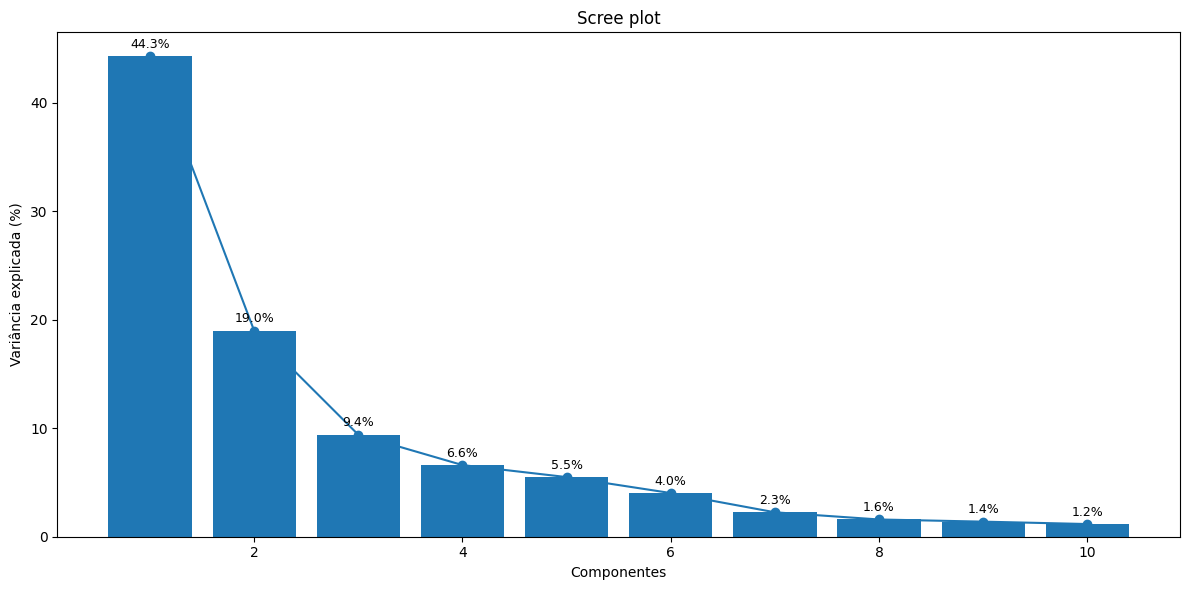

In [10]:
plot_scree(pca_out["expl_var"])


O gráfico de **scree plot** mostra a porcentagem de variância explicada por cada componente principal em uma análise de componentes principais (PCA):

- O **primeiro componente principal (PC1)** explica **44,3%** da variância total dos dados, o que indica que captura uma grande parte da informação.
- O **segundo componente (PC2)** explica **19,0%**, e juntos, PC1 e PC2 já explicam **63,3%** da variância.
- A partir do terceiro componente, a contribuição cai rapidamente: PC3 com 9,4%, PC4 com 6,6%, e assim por diante.
- A partir do quinto componente, a variação explicada fica abaixo de 5% por componente.

A interpretação é a seguinte:

A estrutura dos dados é fortemente dominada pelos primeiros dois componentes. Isso sugere que **a maior parte da informação está concentrada em apenas duas dimensões**, o que pode ser útil para visualização ou seleção de variáveis. Além disso, o "cotovelo" no gráfico aparece entre o segundo e terceiro componente, indicando que **PC1 e PC2 são suficientes para representar a maioria da variabilidade**.

### Dispersão (PCA)

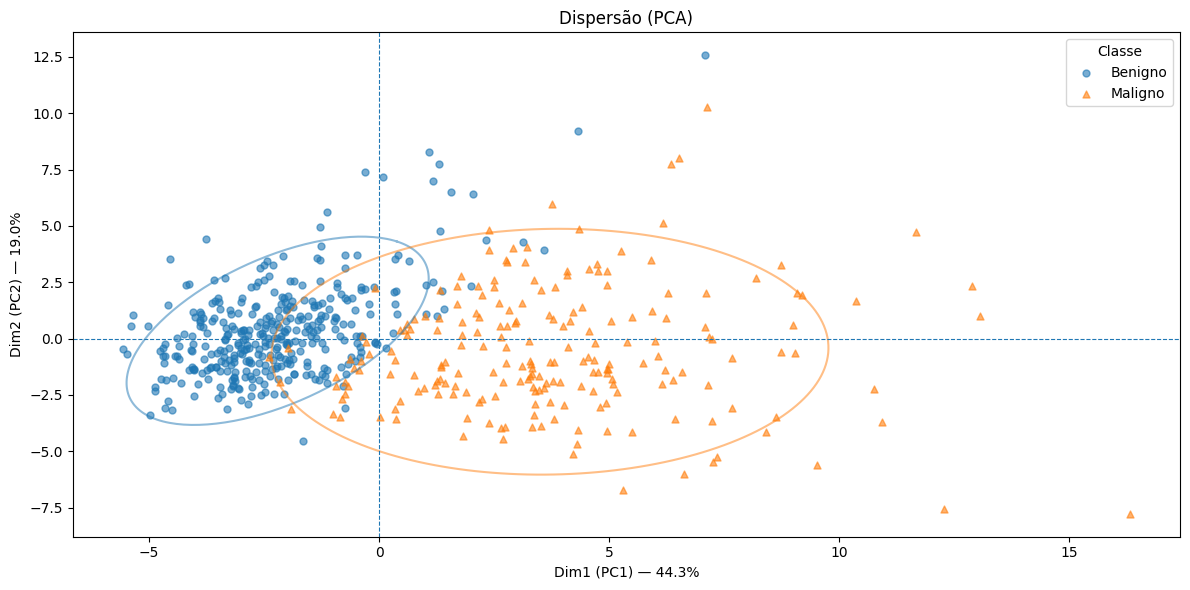

In [11]:
plot_scores(pca_out["scores"], y, pca_out["expl_var"])

Este gráfico de **Dispersão (PCA)** mostra a projeção dos dados no espaço formado pelos dois primeiros componentes principais (PC1 e PC2), com as classes **Benigno** (círculos azuis) e **Maligno** (triângulos laranja), no qual observamos:

- **PC1 (44,3%)**: Captura a maior parte da variabilidade dos dados. Observa-se uma clara separação entre as classes ao longo desse eixo: tumores **malignos** tendem a ter valores mais altos em PC1.
- **PC2 (19,0%)**: Contribui com uma segunda dimensão de variação, ajudando a separar alguns casos que se sobrepõem no PC1.
- **Separação das classes**: Embora haja alguma sobreposição (principalmente na região central), há um **padrão claro de separação** entre benignos e malignos, especialmente no lado direito do gráfico.
- **Formas elípticas**: As elipses indicam a dispersão dos dados por classe, mostrando que os **tumores malignos têm maior variabilidade** em comparação aos benignos.

O PCA revela que os dados são **bem separáveis** em um espaço reduzido de duas dimensões, o que sugere que as varíaveis do dataset podem ser fortemente associadas ao diagnóstico. Isso apoia a viabilidade de modelos preditivos robustos para classificação.

### Círculo de Correlações

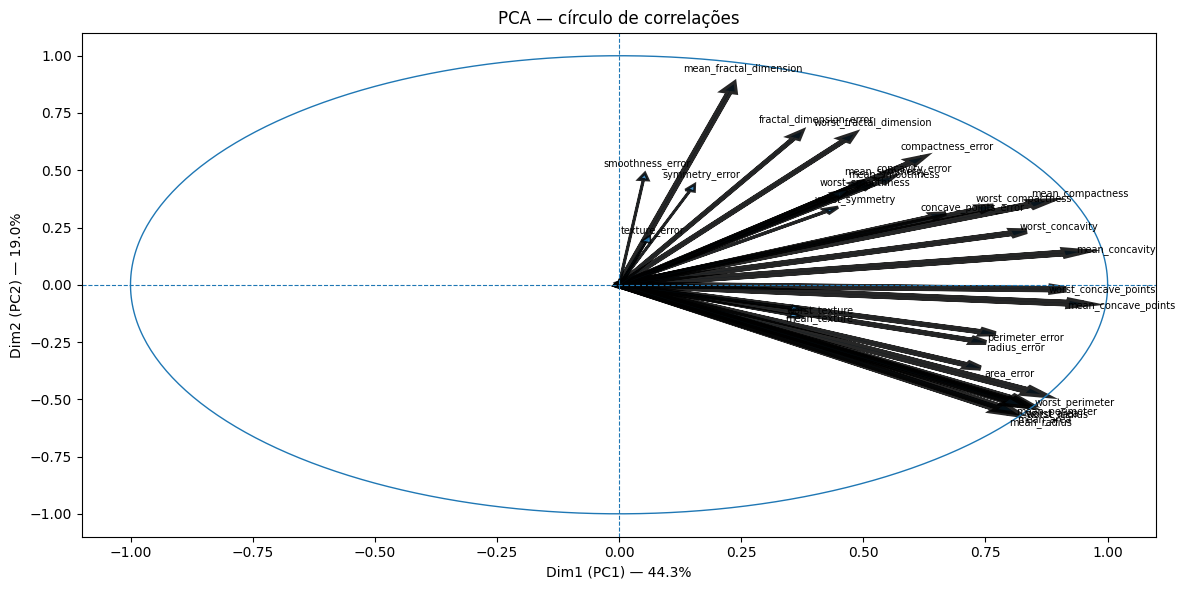

In [12]:
plot_correlation_circle(pca_out["loadings"], pca_out["feature_names"], pca_out["expl_var"])

O **círculo de correlações (correlation circle)** da análise de componentes principais (PCA), mostra como as variáveis originais se projetam nos dois primeiros componentes principais (PC1 e PC2):

- **Eixo horizontal (PC1 – 44,3%)**: Representa a direção com maior variação nos dados. Variáveis que apontam para a direita estão fortemente positivamente correlacionadas com PC1.
- **Eixo vertical (PC2 – 19,0%)**: Segunda direção de máxima variação.

#### 📌 Principais observações:

1. **Grupos de variáveis**:
   - Variáveis como `mean_radius`, `mean_perimeter`, `mean_area`, `worst_radius`, `worst_perimeter` e `worst_area` estão agrupadas no canto inferior direito → indicam **tamanho do núcleo celular**.
   - `mean_compactness`, `worst_compactness`, `concavity`, `concave_points`, `symmetry_error` e `fractal_dimension` estão mais ao centro-direita → relacionadas à **forma e irregularidade** do núcleo.
   - `mean_fractal_dimension`, `worst_fractal_dimension` e `smoothness_error` estão mais ao topo → ligadas à **complexidade geométrica** e **irregularidade da superfície**.

2. **Direção dos vetores**:
   - Quanto mais longo o vetor, maior a influência da variável no componente principal.
   - Vetores próximos entre si indicam alta correlação entre as variáveis.
   - Exemplo: `mean_radius` e `mean_perimeter` têm direções muito próximas → altamente correlacionadas.

3. **Interpretação clínica**:
   - O **PC1** está fortemente associado ao **tamanho médio e pior** do núcleo celular (maior em tumores malignos).
   - O **PC2** está ligado à **forma, irregularidade e complexidade fractal**, que são características marcantes de células cancerosas.


### O que revela o círculo de correlações?
- As **variáveis de tamanho** (radius, perimeter, area) dominam o primeiro componente principal.
- As **variáveis de forma e irregularidade** (compactness, concavity, fractal dimension) contribuem significativamente para o segundo componente.
- Isso confirma que **tumores malignos tendem a ter núcleos maiores, mais irregulares e com bordas frágeis**.

Essa interpretação ajuda a entender qualitativamente **por que os modelos conseguem distinguir bem as classes**, pois as características nucleares mais relevantes estão bem capturadas pelos componentes principais.

### Biplot — Indivíduos e Variáveis

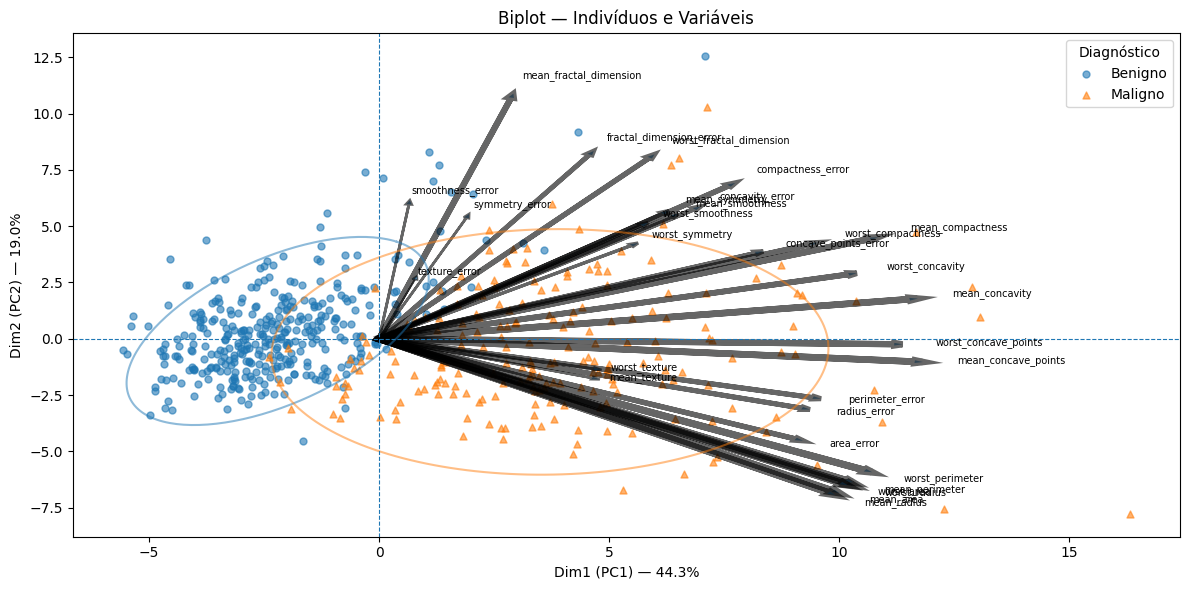

In [13]:
plot_biplot(
    scores=pca_out["scores"],
    y=y,
    loadings=pca_out["loadings"],
    feature_names=pca_out["feature_names"],
    expl_var=pca_out["expl_var"],
    n_std=2.0,              # elipses ~2 desvios
    max_vars=None,          # ou, por ex., 25 para enxugar labels
    thickness_by="cos2",    # deixa as setas "importantes" mais espessas
)


Este **biplot — Indivíduos e Variáveis** combina, em um único gráfico, a projeção dos casos (indivíduos) no espaço reduzido do PCA com a representação das variáveis originais como vetores. Ele permite uma análise integrada que **superioriza** as interpretações isoladas do gráfico de dispersão e do círculo de correlações.


#### **Relação entre variáveis e classes**
- Quanto mais **próximo um vetor está de um grupo de indivíduos**, maior sua relevância para caracterizar aquela classe.
- Por exemplo: `worst_perimeter` e `worst_area` estão próximos dos triângulos laranja → são **indicadores fortes de malignidade**.
- Variáveis como `texture_error` e `smoothness_error` têm direção intermediária, sugerindo influência moderada.

#### **Conexão entre variáveis e componentes principais**
- O **PC1** é dominado por características de **tamanho** (radius, perimeter, area) e **forma irregular** (concavity, concave points).
- O **PC2** captura variações relacionadas à **textura, simetria e complexidade fractal**, ajudando a separar casos que são similares em tamanho, mas diferem em forma.

#### **Inferência clínica**
- O biplot confirma que:
  - Tumores malignos têm **núcleos maiores** (maior `radius`, `perimeter`, `area`),
  - **Formas mais irregulares** (alta `concavity`, `concave_points`),
  - **Bordas mais complexas** (alto `fractal_dimension`),
  - E maior **variabilidade nas medidas** (`error`).


### O que o biplot acrescenta?

> O **biplot é uma ferramenta poderosa** porque **integra a visão dos dados (indivíduos) com a visão das variáveis**, permitindo:
- Visualizar a **separação entre classes**,
- Identificar **quais variáveis explicam melhor essa separação**,
- Interpretar **qualitativamente os padrões clínicos** observados.

👉 É essencial para **entender não apenas se os modelos funcionam**, mas **por que funcionam**, fornecendo insights clínicos valiosos para a decisão médica e a construção de modelos interpretáveis.

### Rank de variáveis 

#### O que cada coluna mede

* **`abs_corr_y`**
  |ρ(x, y)| com `y` binário (1 = **Maligno**). É a correlação linear *absoluta* entre a variável e o alvo.  
  • Quanto maior, mais a variável cresce/diminui “junto” com a chance de maligno (sinal é ignorado no ranking).

* **`mi`**
  *Mutual information* (informação mútua) entre a variável e `y`. Capta dependências **não lineares**.  
  • Maior = mais informação exclusiva sobre o alvo.

* **`contrib_PC1` / `contrib_PC2`**
  Contribuição (%) da variável para cada componente principal (PC) — calculada a partir dos *loadings*.  
  • Em termos práticos: quanto aquela variável “puxa” o eixo PC1/PC2. Como vimos no PCA, **PC1 concentra a separação Benigno ↔ Maligno**, então `contrib_PC1` pesa mais no ranking.

* **`cos2_PC1` / `cos2_PC2`**
  **cos²** = (loading)²: qualidade de representação da variável no eixo PC.  
  • Ex.: `cos2_PC1` alto ⇒ a variável está bem “alinhada” com PC1.

* **`loading_PC1` / `loading_PC2`**
  Cargas das variáveis nos eixos (correlação da variável padronizada com o PC).  
  • O **módulo** indica força de associação; o **sinal** só dá direção no biplot (positivo/negativo), não muda a importância.

* **`r_abs_corr_y`, `r_mi`, `r_contrib_PC1`, `r_cos2_PC1`**
  **Ranks normalizados (0–1)** dessas métricas (1.0 = melhor colocada).  
  • São as versões “comparáveis” entre si; usamos elas para compor um placar único.

* **`score_composite`**
  Média dos ranks escolhidos (aqui: `abs_corr_y`, `mi`, `contrib_PC1`, `cos2_PC1`).  
  • Quanto mais perto de **1.0**, mais a variável é consistentemente forte nos quatro critérios.  
  • A tabela já está **ordenada** por esse score (maior → menor).  


In [14]:
# Ranking e poda por correlação
rank_df = rank_features(X_df, y, pca_out["contrib_df"])
rank_df.head(16)

,abs_corr_y,mi,contrib_PC1,contrib_PC2,cos2_PC1,cos2_PC2,loading_PC1,loading_PC2,r_abs_corr_y,r_mi,r_contrib_PC1,r_cos2_PC1,score_composite
mean_concave_points,0.776614,0.438806,6.804468,0.120878,0.905334,0.006892,0.951490,-0.083016,0.931034,0.896552,1.000000,1.000000,0.956897
worst_concave_points,0.793566,0.436255,6.294377,0.006818,0.837466,0.000389,0.915132,-0.019716,1.000000,0.862069,0.931034,0.931034,0.931034
worst_perimeter,0.782914,0.471842,5.599834,3.995139,0.745057,0.227778,0.863167,-0.477261,0.965517,1.000000,0.862069,0.862069,0.922414
mean_concavity,0.696360,0.375447,6.677081,0.361987,0.888385,0.020638,0.942542,0.143660,0.724138,0.793103,0.965517,0.965517,0.862069
worst_radius,0.776454,0.451230,5.198247,4.834122,0.691626,0.275611,0.831641,-0.524987,0.896552,0.931034,0.793103,0.793103,0.853448
worst_area,0.733825,0.464313,5.056676,4.811524,0.672790,0.274323,0.820238,-0.523759,0.827586,0.965517,0.724138,0.724138,0.810345
mean_perimeter,0.742636,0.402361,5.177322,4.630302,0.688842,0.263991,0.829965,-0.513800,0.862069,0.827586,0.758621,0.758621,0.801724
worst_concavity,0.659610,0.315259,5.233458,0.959697,0.696311,0.054716,0.834453,0.233914,0.689655,0.655172,0.827586,0.827586,0.750000
mean_compactness,0.596534,0.213439,5.725748,2.307106,0.761810,0.131537,0.872817,0.362680,0.655172,0.517241,0.896552,0.896552,0.741379
mean_area,0.708984,0.360023,4.883878,5.339645,0.649800,0.304433,0.806101,-0.551755,0.758621,0.724138,0.689655,0.689655,0.715517


### O que o resultado mostra (top-16)?

1. **Irregularidade da borda domina o topo**

   * `mean_concave_points`, `worst_concave_points`, `mean_concavity`, `worst_concavity`, `mean_compactness`, `worst_compactness` aparecem com **scores** altos e `contrib_PC1`/`cos2_PC1` elevados.
   * Interpretação: medidas de **concavidade/“pontos côncavos”/compactness** são fortemente associadas a malignidade (faz sentido clínico e bate com o biplot: PC1 \~ “irregularidade + tamanho”).

2. **Tamanho/escala morfológica também é muito forte**

   * `worst_perimeter`, `worst_radius`, `worst_area`, `mean_perimeter`, `mean_area`, `mean_radius` também estão no topo.
   * Essas variáveis são **altamente colineares entre si** (raio ↔ perímetro ↔ área). No ranking, elas sobem porque têm **alta correlação com `y`** e **alta contribuição em PC1**.

3. **Variáveis de "erro" entram, mas um pouco abaixo**

   * `perimeter_error`, `radius_error`, `area_error` aparecem com pontuação boa, porém menor que os "worst/mean".
   * Podem trazer *ganho marginal*; avaliaremos na poda (e, se necessário, via importância/SelectFromModel).

4. **PC2 pesa menos no ranking**

   * Não estamos está vendo `fractal_dimension` no top-16 porque o score composto **prioriza PC1** (onde está a separação de classes).
   * Ainda assim, nos os gráficos de **contribuições/cos²** de PC2 e `fractal_dimension_*` mostrou ter papel relevante, podemos "reservar" 1 variável desse grupo no conjunto reduzido por diversidade de sinais.

---

### Leitura detalhada de alguns casos:

* **`mean_concave_points`**
  • `abs_corr_y=0.7766` e `mi=0.4388`: forte associação (linear e não linear) com malignidade.
  • `contrib_PC1=6.80%` e `cos2_PC1=0.905`: **muito alinhada à PC1**.
  • Ranks ≈ (0.93, 0.90, 1.00, 1.00) ⇒ **`score_composite=0.9569`** (campeã).

* **`worst_perimeter`**
  • `abs_corr_y=0.7829`, `mi=0.4718` (excelentes).
  • `contrib_PC1=5.60%`, `cos2_PC1=0.745`: também muito forte em PC1.
  • `loading_PC2=-0.477` dá uma componente razoável em PC2 (direção oposta no biplot), mas a força vem de PC1.
  • `score_composite=0.9224`.

* **`mean_concavity`**
  • `abs_corr_y=0.6964` (um pouco menor), mas `contrib_PC1=6.68%` e `cos2_PC1=0.888` elevam o rank.
  • `score_composite=0.8621`.

Esse padrão se repete: **concave_points/concavity/compactness** (irregularidade) e **radius/perimeter/area** (tamanho) lideram, com os **"worst"** geralmente acima dos **"mean"**.

---

### Como isso guia a redução de variáveis?

* O `rank_df` define a **prioridade** para a **poda por correlação**.
* Ex.: no grupo **tamanho** {`worst_perimeter`, `worst_radius`, `worst_area`, `mean_perimeter`, `mean_area`, `mean_radius`} vamos **manter 1–2** representativos (p.ex., `worst_perimeter` **ou** `worst_radius`).
* No grupo **irregularidade** {`mean_concave_points`, `worst_concave_points`, `mean_concavity`, `worst_concavity`, `mean_compactness`, `worst_compactness`} manteremos **2–3**, começando pelos mais bem ranqueados (p.ex., `worst_concave_points` e `mean_concave_points` **ou** `mean_concavity`).
* Variáveis de **erro** e outros grupos entram **se** passarem nos **guard-rails** (ΔROC-AUC ≤ 0,01 e ΔRecall ≤ 0,02 vs. full).

> Em resumo: as **top features** refletem exatamente o que vimos no PCA — **irregularidade de borda** e **tamanho** são os motores da separação. O `score_composite` agrega vários sinais e entrega uma ordem coerente para fazermos a **poda (ρ≥0,90)** com mínima perda preditiva.


### Poda por correlação

#### Como o `selected` é construído:

1. **Prioridade**: primeiro ordenamos as variáveis por `score_composite` (média dos ranks normalizados de `abs_corr_y`, `mi`, `contrib_PC1`, `cos2_PC1`).
   → `priority = rank_df.index.tolist()` já está **do melhor para o pior**.

2. **Matriz de correlação**: calculamos `corr = X_df.corr(method="spearman").abs()`. Usamos **Spearman** (por postos) é mais robusto a assimetria e outliers.

3. **Poda gulosa (threshold = 0.90)**:

   ```python
   kept = []
   for feat in priority:
       if all(corr.loc[feat, k] < 0.90 for k in kept):
           kept.append(feat)
   ```

   • Passamos de cima para baixo.
   • **Mantemos** a variável se ela não tem |ρ| ≥ 0.90 com **nenhuma** já mantida.
   • Se tiver, é **descartada** como redundante (fica representada por quem entrou antes).


In [15]:
selected = prune_by_correlation(X_df, priority=rank_df.index.tolist(), threshold=0.90, method="spearman")
selected[:16]     # exibir primeiras 16


['mean_concave_points',
 'worst_perimeter',
 'worst_concavity',
 'mean_compactness',
 'perimeter_error',
 'concave_points_error',
 'concavity_error',
 'worst_smoothness',
 'mean_smoothness',
 'compactness_error',
 'worst_texture',
 'worst_symmetry',
 'mean_symmetry',
 'worst_fractal_dimension',
 'fractal_dimension_error',
 'mean_fractal_dimension']

#### Por que essas ficaram

* **Representantes por "família"**:

  * **Irregularidade da borda**: `mean_concave_points`, `worst_concavity`, `mean_compactness`, além dos **erros** `concave_points_error`, `concavity_error`, `compactness_error`.  
    → Essas variáveis são muito informativas (alto `abs_corr_y`, `mi`, `contrib_PC1`) e, **entre si**, várias têm ρ<0.90 — então mais de uma passou.
  * **Tamanho/escala**: `worst_perimeter` entrou e **bloqueou** pares supercolineares como `mean_perimeter`, `worst_radius`, `mean_radius`, `worst_area`, `mean_area` (tipicamente |ρ|≥0.90 entre si).  
    → Mantivemos **um representante forte** do bloco de tamanho.
  * **Textura**: `worst_texture` representou o grupo (se `mean_texture` ou `texture_error` tiverem ρ≥0.90 com ele, são podadas; se <0.90 podem aparecer depois do 15º).
  * **Suavidade** (*smoothness*): `worst_smoothness` e `mean_smoothness` passaram porque a correlação entre elas ficou **<0.90**.
  * **Simetria**: `worst_symmetry` e `mean_symmetry` idem (ρ<0.90 entre si).
  * **Fractalidade**: `worst_fractal_dimension` e `fractal_dimension_error` ficaram; `mean_fractal_dimension` provavelmente foi **podada** por alta correlação com `worst_fractal_dimension` ou ficou abaixo na prioridade.

* **Por que alguns "_error" entraram**: apesar de correlacionarem com as medidas base, muitas vezes **não atingem 0.90** e trazem **variação** (complementar), então passaram pelo filtro.


### Quem "bloqueou' quem?

In [16]:
corr = X_df.corr(method="spearman").abs()
for f in selected[:16]:
    altos = corr.loc[f].sort_values(ascending=False)
    print(f, "bloqueia:", [v for v in altos.index[1:] if altos[v] >= 0.90][:8])


mean_concave_points bloqueia: ['worst_concave_points', 'mean_concavity']
worst_perimeter bloqueia: ['worst_radius', 'worst_area', 'mean_perimeter', 'mean_area', 'mean_radius']
worst_concavity bloqueia: ['mean_concavity', 'worst_compactness', 'worst_concave_points']
mean_compactness bloqueia: ['worst_compactness']
perimeter_error bloqueia: ['radius_error', 'area_error']
concave_points_error bloqueia: []
concavity_error bloqueia: []
worst_smoothness bloqueia: []
mean_smoothness bloqueia: []
compactness_error bloqueia: []
worst_texture bloqueia: ['mean_texture']
worst_symmetry bloqueia: []
mean_symmetry bloqueia: []
worst_fractal_dimension bloqueia: []
fractal_dimension_error bloqueia: []
mean_fractal_dimension bloqueia: []


### Resumo

* Ordenamos por um **placar composto** (informação para o alvo + importância no PC1).
* Aplicamos uma **poda por correlação (Spearman ≥ 0.90)** para eliminar redundantes.
* O conjunto resultante traz **um representante forte do bloco "tamanho"** (`worst_perimeter`) e **múltiplos sinais de irregularidade/forma** (concavity/compactness/concave_points), além de **textura, suavidade, simetria e fractalidade**, cobrindo bem os eixos que distinguem **Benigno vs. Maligno** — agora com **bem menos variáveis** e pouca redundância.


In [17]:
# 16 colunas selecionadas
pruned_cols = selected[:16]
pruned_cols

['mean_concave_points',
 'worst_perimeter',
 'worst_concavity',
 'mean_compactness',
 'perimeter_error',
 'concave_points_error',
 'concavity_error',
 'worst_smoothness',
 'mean_smoothness',
 'compactness_error',
 'worst_texture',
 'worst_symmetry',
 'mean_symmetry',
 'worst_fractal_dimension',
 'fractal_dimension_error',
 'mean_fractal_dimension']

> **Análise PCA concluída (interpretação, não redução direta):**
>
> * Scree: PC1 ≈ 44,3%, PC2 ≈ 19,0% (≈ 63,3% nas duas).
> * PC1×PC2 com classes: separação principalmente ao longo de **PC1**.
> * Círculo de correlações e contribuições: **irregularidade da borda** (concave_points/concavity/compactness) e **tamanho** (radius/perimeter/area) são os eixos dominantes.
> * Ranqueamento supervisionado (|corr|, MI, contrib\_PC1, cos²\_PC1) gerou `rank_df`.
> * **Poda por correlação (Spearman, ρ≥0,90)** removeu redundâncias mantendo um representante por bloco altamente colinear — resultando no conjunto `selected` (primeiras 16 listadas acima).
> * Este conjunto reduzido diminui o número de variáveis mantendo sinais fortes para o diagnóstico.
>
> **Próximo passo:** rodar **seletores *embedded***


### Seletores *Embedded*

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, average_precision_score,
    recall_score, precision_score, f1_score, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# pré-processos
pre_lr  = Pipeline([("imp", SimpleImputer(strategy="median")),
                    ("yj",  PowerTransformer(method="yeo-johnson"))])
pre_tree = Pipeline([("imp", SimpleImputer(strategy="median"))])

pos = int((df["diagnosis"]=="Maligno").sum())
neg = len(df) - pos
scale_pos_weight = neg/pos

### Seletores *embedded* com CV: o que a função `run_embedded_selector(...)` faz

Queremos reduzir variáveis **sem vazar informação** e medindo **estabilidade** de seleção. Para isso, usaremos a função `run_embedded_selector` que executa **seleção *embedded*** com `SelectFromModel` **dentro** de um `Pipeline`, avaliada com **validação cruzada estratificada**.

#### Objetivo
- Selecionar **top-k** variáveis por *fold* usando um **modelo seletor** (ex.: LR L1/ElasticNet, RF, XGB).
- Treinar um **classificador final** apenas com as variáveis selecionadas **naquele fold**.
- Medir:
  - **Estabilidade** de seleção (frequência 0..1 por variável ao longo dos folds).
  - **Desempenho preditivo** médio (ROC-AUC, PR-AUC/AP, Recall, F1).

#### Por que assim
- **Sem *leakage***: tudo (pré-processo, seleção, treino) acontece **dentro do fold** de treino.
- **Estabilidade**: refazendo a seleção em cada fold, medimos quão **consistente** é cada variável.
- **Top-k controlado**: `SelectFromModel(threshold=-np.inf, max_features=top_k)` garante “pegar as **k** mais importantes”.


#### Assinatura e parâmetros

```python
run_embedded_selector(
    name,              # rótulo do experimento (ex.: "LR_L1", "RF", "XGB")
    X_df,              # DataFrame de features (linhas = amostras, colunas = variáveis)
    y,                 # vetor 1D com rótulos (0/1), 1 = Maligno
    *,
    selector_estimator,# modelo para ranquear features (coef_/feature_importances_)
    clf_estimator,     # classificador final treinado após a seleção
    preprocess=None,   # Pipeline de pré-processo (ex.: imputer + Yeo-Johnson p/ LR)
    top_k=16,          # número máximo de variáveis a manter por fold
    cv_splits=5,       # n° de folds (estratificados)
    random_state=42    # semente p/ reprodutibilidade
)
````

**Boas práticas ao configurar:**

* **LR**: usar `class_weight="balanced"` e **Yeo–Johnson** no `preprocess` (escala + redução de *skew*).
* **RF/XGB**: apenas imputação; para XGB usar `scale_pos_weight = (neg/pos)`.


#### Passo a passo (o que a função faz em cada fold)

1. **Split estratificado** (`StratifiedKFold`): mantém proporção de classes em treino/teste.
2. **Pipeline**:

   * *(opcional)* `pre`: `SimpleImputer` (+ `PowerTransformer` na LR).
   * `sel`: `SelectFromModel(estimator=selector_estimator, threshold=-np.inf, max_features=top_k)`
     → treina o *selector* no **treino** do fold e marca as **top-k** variáveis.
   * `clf`: treina o classificador **apenas** com as variáveis selecionadas **naquele fold**.
3. **Contagem de seleção**: coletamos a máscara `get_support()` e somamos 1 para cada variável escolhida no fold.
4. **Avaliação**:

   * Probabilidade/score no conjunto de **teste** do fold (`predict_proba` ou `decision_function`).
   * Métricas:

     * **ROC-AUC** e **AP (PR-AUC)**: baseadas em probabilidades (independentes de limiar).
     * **Recall** e **F1**: com limiar 0.5 (padrão para comparação; podemos otimizar limiar depois).


#### Saídas da função

* **`freq`** *(Series)*: frequência de seleção por variável (**0..1**), ordenada do mais estável para o menos.

  * 1.0 ⇒ a variável entrou em **todos** os folds; 0.2 ⇒ entrou em **1/5** dos folds.
* **`perf`** *(DataFrame 1 linha)*: médias das métricas ao longo dos folds (colunas: `roc_auc`, `ap`, `recall`, `f1`).

> Usaremos `freq` para montar um **consenso de variáveis estáveis** (podendo combinar métodos: LR L1, ElasticNet, RF, XGB) e, se necessário, aplicar **poda por correlação** novamente (ρ≥0,90) para remover redundâncias antes da comparação **Full vs. Reduzido**.


#### Pseudocódigo (resumo da lógica)

```text
iniciar counts = 0 para cada feature
para cada fold (treino, teste):
    ajustar [pre] no treino
    ajustar SelectFromModel (top-k) no treino
    ajustar classificador nos dados selecionados
    prever no teste → coletar métricas
    somar 1 nas features selecionadas deste fold
freq = counts / n_folds
perf = média das métricas nos folds
retornar (freq, perf)
```

In [19]:
def run_embedded_selector(name, X_df, y, *, selector_estimator, clf_estimator,
                          preprocess=None, top_k=16, cv_splits=5, random_state=42):
    """
    Executa SelectFromModel dentro de um Pipeline com CV e retorna:
      - freq: frequência de seleção por variável (0..1) ao longo dos folds
      - perf: métricas médias (ROC-AUC, AP, Recall, F1)
    """
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    feats = X_df.columns.to_numpy()
    counts = np.zeros(len(feats), dtype=int)
    metrics = []

    for tr, te in skf.split(X_df, y):
        Xtr, Xte = X_df.iloc[tr], X_df.iloc[te]
        ytr, yte = y[tr], y[te]

        steps = []
        if preprocess is not None:
            steps.append(("pre", preprocess))
        steps.append(("sel", SelectFromModel(estimator=selector_estimator,
                                             threshold=-np.inf,   # top-k
                                             max_features=top_k)))
        steps.append(("clf", clf_estimator))
        pipe = Pipeline(steps)
        pipe.fit(Xtr, ytr)

        # quais variáveis foram selecionadas neste fold?
        mask = pipe.named_steps["sel"].get_support()
        counts += mask.astype(int)

        # avaliação (probabilidade ou decisão)
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            proba = pipe.predict_proba(Xte)[:, 1]
        else:
            proba = pipe.decision_function(Xte)
        yhat = (proba >= 0.5).astype(int)

        metrics.append({
            "roc_auc": roc_auc_score(yte, proba),
            "ap":      average_precision_score(yte, proba),
            "recall":  recall_score(yte, yhat),
            "f1":      f1_score(yte, yhat)
        })

    freq = pd.Series(counts / cv_splits, index=feats, name=f"freq_{name}").sort_values(ascending=False)
    perf = pd.DataFrame(metrics).mean().to_frame(name).T
    return freq, perf


### Rodar os quatro seletores (L1, ElasticNet, RF, XGB)


#### Por que estes quatro modelos (LR L2, LR ElasticNet, Random Forest, XGBoost)?

Escolhemos um **conjunto complementar** de algoritmos clássicos para dados tabulares, todos bem documentados e com forte desempenho relatado em publicações e exemplos públicos (incluindo a própria página do dataset da UCI: Breast Cancer Wisconsin (Diagnostic)). 

- **Logistic Regression (L2)** — *baseline* linear, interpretável, boa calibração; serve de referência para as demais abordagens.
- **Logistic Regression (ElasticNet)** — combina L1+L2, lida melhor com **colinearidade** e pode induzir **esparsidade**, sendo útil tanto como **seletor embutido** quanto como classificador.
- **Random Forest (bagging)** — robusto a **assimetria/outliers**, quase sem necessidade de *scaling*, fornece importâncias de variáveis e costuma performar bem em cenários tabulares.
- **XGBoost (gradient boosting)** — estado da arte em muitos problemas tabulares; lida com **interações não lineares** e **desbalanceamento** via `scale_pos_weight`. 


#### Por que chamamos "cada modelo duas vezes", quais hiperparâmetros e por que `auc` no XGBoost

##### 1) Dois papéis distintos no Pipeline: **seletor** vs **classificador**
Nosso `run_embedded_selector(...)` monta um `Pipeline` com:
1) *(opcional)* **pré-processo** (`pre`)
2) **seletor** (`sel`) = `SelectFromModel(estimator=selector_estimator, max_features=top_k)`
3) **classificador** (`clf`) = `clf_estimator`

Chamamos (instanciamos) **dois estimadores** porque **os papéis são diferentes**:
- O **seletor** treina um modelo para **ranquear** variáveis (coeficientes/`feature_importances_`) e marca as **top-k** *dentro do fold de treino*.
- O **classificador** treina um modelo **final** apenas com as variáveis escolhidas naquele fold, e é **avaliado** no teste do fold.

Isso nos permite, por exemplo:
- **LR L1 para selecionar** (sparse) e **LR L2 para classificar** (geralmente mais estável/calibrada).
- Em RF/XGB, usar o mesmo tipo de modelo para ambos os estágios, **mas com instâncias diferentes** para evitar compartilhar estado e manter o código explícito.

> Tecnicamente, reutilizar o *mesmo* objeto em dois steps é ruim: o `fit` do primeiro sobrescreve atributos usados depois. Por isso **criamos uma instância para o seletor** e **outra para o classificador** (mesmo quando os hiperparâmetros são idênticos).


##### 2) Hiperparâmetros "iniciais" (por que esses valores)
Nosso objetivo aqui é **gerar um ranking estável** e uma **baseline**. Não é o estágio de *tuning pesado*; escolhemos valores **sensatos** e **conservadores**:

**Logistic Regression (seletor L1 e classificador L2/EN)**
- `solver="saga"`, `max_iter=3000`: robusto para L1/ElasticNet e garante convergência com muitos atributos.
- `C=1.0`: regularização padrão (podemos ajustar depois).
- `class_weight="balanced"`: compensa o desbalanceamento moderado.
- **L1 como seletor**: incentiva esparsidade → ótimo para `SelectFromModel`.
- **L2/ElasticNet como classificador**: costuma dar **menor variância** e **melhor calibração** de probabilidades.

**Random Forest**
- `n_estimators=600`: florestas maiores estabilizam importâncias e predição (custo ainda ok).
- `max_depth=None`: deixa as árvores crescerem; a diversidade vem do *bagging*.
- `class_weight="balanced_subsample"`: ajusta pesos por amostra em cada árvore para o desbalanceamento.

**XGBoost**
- `n_estimators=800`, `learning_rate=0.05`: *boosting* mais "lento" e estável; melhor generalização.
- `max_depth=4`: controla complexidade.
- `subsample=0.9`, `colsample_bytree=0.9`: regularização estocástica (reduz overfitting e estabiliza importâncias).
- `reg_lambda=1.0`, `reg_alpha=0.0`: regularizações padrão (podemos testar `alpha>0` depois).
- `scale_pos_weight=neg/pos`: corrige desbalanceamento na função de perda.
- `random_state=42`: reprodutibilidade.

> Depois, quando fecharmos a lista candidata de variáveis, podemos **refinar hiperparâmetros** (grid ou bayesiano) já com o **conjunto reduzido**, o que é mais barato e focado.

##### 3) Nossa métrica principal é **Recall** — por que usar `eval_metric="auc"` no XGB?
- **Métrica principal de decisão** (no relatório): **Recall da classe Maligno (1)**, pois falsos negativos são críticos em saúde.
- No **treino interno do XGBoost**, passamos `eval_metric="auc"` por três razões:
  1) **`recall` não é diferenciável** e não serve de métrica suave para orientar o *boosting* (que otimiza uma perda contínua).
  2) **AUC** é **independente de limiar** e estável para monitorar o treinamento (mesmo com classes desbalanceadas).
  3) Coerência com nossas avaliações externas, onde também reportamos **ROC-AUC** e **Average Precision (AP/PR-AUC)** além do **Recall**.

Alternativas válidas:
- `eval_metric="aucpr"` (PR-AUC) pode ser **ainda mais alinhada** ao desbalanceamento. É totalmente aceitável substituirmos por `"aucpr"` — o **Recall** seguirá sendo a métrica **primária** para comparar painéis de variáveis; a métrica de *treino* do XGB é apenas para **monitoramento**/estabilidade, não para definir o *threshold*.

> Resumo: **avaliamos e comparamos por Recall (primário)** + ROC-AUC/AP/F1; **treinar com `auc`/`aucpr`** no XGB é apenas uma escolha técnica para guiar o boosting de forma estável e sem depender de limiar. Depois ajustaremos o limiar se quisermos maximizar Recall.

In [20]:
X_df = df.drop(columns=["diagnosis"])
y    = (df["diagnosis"] == "Maligno").astype(int).to_numpy()

# 1) LR L1
sel_lr_l1 = LogisticRegression(penalty="l1", solver="saga", C=1.0, max_iter=4000, n_jobs=-1,
                               class_weight="balanced", random_state=42)
clf_lr    = LogisticRegression(penalty="l2", solver="lbfgs", C=1.0, max_iter=4000, n_jobs=-1,
                               class_weight="balanced", random_state=42)
freq_l1, perf_l1 = run_embedded_selector("LR_L1", X_df, y,
    selector_estimator=sel_lr_l1, clf_estimator=clf_lr, preprocess=pre_lr, top_k=16)

# 2) LR ElasticNet
sel_lr_en = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, C=1.0, max_iter=4000, n_jobs=-1,
                               class_weight="balanced", random_state=42)
clf_lr_en = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, C=1.0, max_iter=4000, n_jobs=-1,
                               class_weight="balanced", random_state=42)
freq_en, perf_en = run_embedded_selector("LR_EN", X_df, y,
    selector_estimator=sel_lr_en, clf_estimator=clf_lr_en, preprocess=pre_lr, top_k=16)

# 3) Random Forest
sel_rf = RandomForestClassifier(n_estimators=600, max_depth=None, n_jobs=-1,
                                class_weight="balanced_subsample", random_state=42)
clf_rf = RandomForestClassifier(n_estimators=600, max_depth=None, n_jobs=-1,
                                class_weight="balanced_subsample", random_state=42)
freq_rf, perf_rf = run_embedded_selector("RF", X_df, y,
    selector_estimator=sel_rf, clf_estimator=clf_rf, preprocess=pre_tree, top_k=16)

# 4) XGBoost
sel_xgb = XGBClassifier(
    n_estimators=800, max_depth=4, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=42, eval_metric="auc"
)
clf_xgb = sel_xgb.__class__(**sel_xgb.get_params())
freq_xgb, perf_xgb = run_embedded_selector("XGB", X_df, y,
    selector_estimator=sel_xgb, clf_estimator=clf_xgb, preprocess=pre_tree, top_k=16)

# Frequências e desempenho
freqs = pd.concat([freq_l1, freq_en, freq_rf, freq_xgb], axis=1).fillna(0)
perfs = pd.concat([perf_l1, perf_en, perf_rf, perf_xgb], axis=0)

freqs.head(20), perfs


(                         freq_LR_L1  freq_LR_EN  freq_RF  freq_XGB
 mean_radius                     1.0         0.0      1.0       0.8
 mean_texture                    1.0         1.0      0.6       1.0
 texture_error                   1.0         0.0      0.0       0.6
 area_error                      1.0         1.0      1.0       0.4
 symmetry_error                  1.0         1.0      0.0       0.0
 compactness_error               1.0         1.0      0.0       0.0
 worst_area                      1.0         1.0      1.0       1.0
 worst_smoothness                1.0         1.0      0.8       1.0
 worst_symmetry                  1.0         1.0      0.0       0.0
 worst_concavity                 1.0         1.0      1.0       1.0
 worst_texture                   1.0         1.0      1.0       1.0
 mean_compactness                0.8         1.0      0.4       0.0
 mean_concave_points             0.8         1.0      1.0       1.0
 mean_perimeter                  0.6         0.0

#### Consenso e lista reduzida final (~15 variáveis)

In [21]:
# Média das frequências de seleção (0..1) entre os métodos
freqs["mean_freq"] = freqs.mean(axis=1)

# Prioridade = mais estáveis entre métodos/folds
priority = freqs.sort_values("mean_freq", ascending=False).index.tolist()

# Combinando com a lista "selected" (poda por correlação anterior):
#   - Usando a prioridade por mean_freq e poda por correlação novamente

final_selected_16 = prune_by_correlation(X_df, priority=priority, threshold=0.90, method="spearman")[:16]
final_selected_16, freqs.loc[final_selected_16].round(2)


(['worst_concavity',
  'worst_area',
  'worst_texture',
  'worst_smoothness',
  'mean_concave_points',
  'area_error',
  'mean_compactness',
  'compactness_error',
  'symmetry_error',
  'worst_symmetry',
  'texture_error',
  'concave_points_error',
  'fractal_dimension_error',
  'mean_fractal_dimension',
  'mean_smoothness',
  'worst_fractal_dimension'],
                          freq_LR_L1  freq_LR_EN  freq_RF  freq_XGB  mean_freq
 worst_concavity                 1.0         1.0      1.0       1.0       1.00
 worst_area                      1.0         1.0      1.0       1.0       1.00
 worst_texture                   1.0         1.0      1.0       1.0       1.00
 worst_smoothness                1.0         1.0      0.8       1.0       0.95
 mean_concave_points             0.8         1.0      1.0       1.0       0.95
 area_error                      1.0         1.0      1.0       0.4       0.85
 mean_compactness                0.8         1.0      0.4       0.0       0.55
 compactnes

### Seleção final (16 variáveis) a partir de estabilidade + poda de correlação

**Como chegamos aqui.** Consolidamos as frequências de seleção dos quatro seletores *embedded* (LR L1, LR ElasticNet, RF, XGB), calculamos a **média entre métodos/folds** (`mean_freq`) e aplicamos **poda por correlação** (Spearman, ρ ≥ 0,90) nessa ordem de prioridade, agora cortando **após 16 variáveis**.

**Painel reduzido (16):**
`['worst_concavity','worst_area','worst_texture','worst_smoothness','mean_concave_points','area_error','mean_compactness','compactness_error','symmetry_error','worst_symmetry','texture_error','concave_points_error','fractal_dimension_error','mean_fractal_dimension','mean_smoothness','worst_fractal_dimension']`

#### Leitura por "famílias" de variáveis
- **Irregularidade/forma (núcleo discriminativo):**  
  `worst_concavity` (**mean_freq = 1.00**), `mean_concave_points` (0.95), `mean_compactness` (0.55), `compactness_error` (0.50), `concave_points_error` (0.35).  
  *Comentário:* refletem concavidade/"pontos côncavos"/compacidade — vetores muito alinhados à PC1 e consistentemente preferidos (especialmente `worst_concavity`).
- **Tamanho/escala:**  
  `worst_area` (**1.00**).  
  *Comentário:* representante único do bloco altissimamente colinear (radius/perimeter/area). Ao manter **um** muito estável, evitamos redundância sem perder sinal de "escala".
- **Textura / Suavidade / Simetria:**  
  `worst_texture` (**1.00**), `texture_error` (0.40); `worst_smoothness` (0.95), `mean_smoothness` (0.05); `worst_symmetry` (0.50), `symmetry_error` (0.50).  
  *Comentário:* os *worst_* são consistentemente fortes; os "_error" capturam variabilidade e passaram por **não** atingirem |ρ| ≥ 0,90 com o que já estava selecionado.
- **Fractalidade (complexidade fina):**  
  `mean_fractal_dimension` (0.10), `fractal_dimension_error` (0.10), `worst_fractal_dimension` (0.05).  
  *Comentário:* estabilidade mais baixa (principalmente em RF/XGB), mas trazem diversidade de sinal; entraram porque **não** eram colineares com o conjunto já formado quando atingimos 16.

#### Por que faz sentido
- **Estabilidade primeiro, redundância depois.** A prioridade por `mean_freq` faz com que *worst_concavity*, *worst_area*, *worst_texture*, *worst_smoothness* e *mean_concave_points* subam naturalmente. A poda por correlação impede que variáveis quase duplicadas (ex.: *worst_area* vs *worst_perimeter*) coexistam.
- **Cobertura de sinais.** O conjunto final cobre **irregularidade/forma**, **escala**, **textura/suavidade/simetria** e **fractalidade**, preservando diversidade e evitando colinearidade forte.
- **Trade-offs conscientes.** Alguns itens com **baixa estabilidade** (p.ex., *mean_smoothness*, *worst_fractal_dimension*) foram mantidos porque **não** conflitam por correlação e acrescentam dimensão interpretativa — úteis para comparação *Full vs. Reduzido* sob nossos *guard-rails*.

#### Checagem adicional (estabilidade mínima)

Vamos verificar se um corte de estabilidade melhora o painel sem perder cobertura.

* **Intenção:** testar um subconjunto **ainda mais estável** (≥ 0,30), re-podando por correlação e limitando a **16** para comparação direta.
* **O que observar:** se **Recall(Maligno)** e **ROC-AUC/AP** se mantêm dentro dos *guard-rails* (ΔRecall ≤ 0,02; ΔAUC ≤ 0,01), podemos preferir o painel mais estável; caso contrário, mantemos as 16 atuais.

In [22]:
# Filtro de estabilidade
keep = freqs.query("mean_freq >= 0.30").index.tolist()

# Ordena por estabilidade (maior → menor) e depois intersecta com o filtro
priority = freqs.sort_values("mean_freq", ascending=False).index.tolist()
priority_keep = [f for f in priority if f in keep]

# Poda por correlação com a prioridade correta e limita a 16
final_more_stable_16 = prune_by_correlation(
    X_df, priority=priority_keep, threshold=0.90, method="spearman")[:16]

final_more_stable_16

['worst_concavity',
 'worst_area',
 'worst_texture',
 'worst_smoothness',
 'mean_concave_points',
 'area_error',
 'mean_compactness',
 'compactness_error',
 'symmetry_error',
 'worst_symmetry',
 'texture_error',
 'concave_points_error']

**Objetivo desta célula.** Definir os **pipelines de modelagem** usados na comparação entre conjuntos de variáveis. Cada pipeline encapsula o **pré-processamento** apropriado (imputação + Yeo–Johnson para LR; imputação para RF/XGB) e o **classificador** (LR L2, LR ElasticNet, RF e XGB com `scale_pos_weight`). Assim garantimos **consistência e justiça** na avaliação com `cross_validate`, calculando **Recall (primária)**, **ROC-AUC**, **AP** e **F1** via CV estratificada.


In [23]:
from sklearn.model_selection import cross_validate

def build_pipes():
    """
    Retorna os pipelines de modelagem usados na comparação:
      - LR_L2: Logistic Regression com L2 (baseline estável)
      - LR_EN: Logistic Regression ElasticNet (combina L1+L2, útil com colinearidade)
      - RF: Random Forest
      - XGB: XGBoost (usa scale_pos_weight já definido)
    Requer que 'pre_lr', 'pre_tree' e 'scale_pos_weight' já estejam definidos no notebook.
    """
    pipes = {
        "LR_L2": Pipeline([
            ("pre", pre_lr),
            ("clf", LogisticRegression(
                penalty="l2", solver="lbfgs", C=1.0,
                max_iter=4000, class_weight="balanced",
                n_jobs=-1, random_state=42 
            ))
        ]),
        "LR_EN": Pipeline([
            ("pre", pre_lr),
            ("clf", LogisticRegression(
                penalty="elasticnet", solver="saga", l1_ratio=0.5, C=1.0,
                max_iter=4000, class_weight="balanced",
                n_jobs=-1, random_state=42
            ))
        ]),
        "RF": Pipeline([
            ("pre", pre_tree),
            ("clf", RandomForestClassifier(
                n_estimators=600, max_depth=None, n_jobs=-1,
                class_weight="balanced_subsample", random_state=42
            ))
        ]),
        "XGB": Pipeline([
            ("pre", pre_tree),
            ("clf", XGBClassifier(
                n_estimators=800, max_depth=4, learning_rate=0.05,
                subsample=0.9, colsample_bytree=0.9,
                reg_lambda=1.0, reg_alpha=0.0,
                scale_pos_weight=scale_pos_weight,
                n_jobs=-1, random_state=42, eval_metric="auc"
            ))
        ]),
    }
    return pipes


**Objetivo desta célula.** Avaliar, com **CV estratificada (5 folds)**, o desempenho dos diferentes **conjuntos de variáveis** — *Full*, *FinalSelected16* e *MoreStable12* (resultado da poda) — usando os **mesmos pipelines** definidos em `build_pipes()`. A função `eval_feature_set` roda `cross_validate` para cada modelo (LR_L2, LR_EN, RF, XGB) e retorna uma tabela com **média e desvio-padrão** de **ROC-AUC**, **AP**, **Recall** (métrica primária) e **F1**; em seguida, concatenamos os resultados para comparação lado a lado.

In [24]:
def eval_feature_set(name, cols, cv_splits=5):
    Xsel = X_df[cols]
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scoring = {"roc_auc":"roc_auc", "ap":"average_precision", "recall":"recall", "f1":"f1"}
    rows = []
    for mname, pipe in build_pipes().items():
        scores = cross_validate(pipe, Xsel, y, cv=cv, scoring=scoring, n_jobs=-1)
        row = {"set": name, "model": mname}
        for met in scoring.keys():
            row[f"{met}_mean"] = float(np.mean(scores[f"test_{met}"]))
            row[f"{met}_std"]  = float(np.std(scores[f"test_{met}"]))
        rows.append(row)
    return pd.DataFrame(rows)

full_cols = list(X_df.columns)
cmp_full         = eval_feature_set("Full", full_cols, cv_splits=5)
cmp_final_sel    = eval_feature_set("FinalSelected16", final_selected_16, cv_splits=5)
# Nomeamos de MoreStable12 porque a poda resultou em 12 variáveis
cmp_more_stable  = eval_feature_set("MoreStable12", final_more_stable_16, cv_splits=5)
comparison = pd.concat([cmp_full, cmp_final_sel, cmp_more_stable], ignore_index=True)


**Objetivo desta célula.** Exibir, em formato de tabela HTML, a **comparação de desempenho (CV 5 folds)** entre os conjuntos de variáveis já avaliados, facilitando a leitura lado a lado de **ROC-AUC**, **AP**, **Recall** e **F1** (médias e desvios-padrão) para cada modelo.

In [25]:
from IPython.display import display, HTML

print("\n=== Comparação CV (5 folds) — Full vs FinalSelected16 vs MoreStable16 ===")
display(HTML(comparison.round(4).to_html()))


=== Comparação CV (5 folds) — Full vs FinalSelected16 vs MoreStable16 ===


,set,model,roc_auc_mean,roc_auc_std,ap_mean,ap_std,recall_mean,recall_std,f1_mean,f1_std
0,Full,LR_L2,0.9964,0.0049,0.9954,0.0057,0.9576,0.0275,0.9554,0.0115
1,Full,LR_EN,0.9965,0.0045,0.9954,0.0052,0.9577,0.0309,0.9577,0.0118
2,Full,RF,0.9906,0.0065,0.9889,0.0063,0.9341,0.0499,0.9448,0.0172
3,Full,XGB,0.9939,0.0051,0.9922,0.0059,0.9433,0.0387,0.9455,0.0069
4,FinalSelected16,LR_L2,0.9970,0.0043,0.9962,0.0049,0.9717,0.0232,0.9628,0.0133
5,FinalSelected16,LR_EN,0.9968,0.0044,0.9959,0.0050,0.9670,0.0189,0.9604,0.0111
6,FinalSelected16,RF,0.9942,0.0033,0.9924,0.0038,0.9340,0.0375,0.9540,0.0197
7,FinalSelected16,XGB,0.9958,0.0036,0.9942,0.0046,0.9623,0.0239,0.9669,0.0134
8,MoreStable12,LR_L2,0.9974,0.0039,0.9966,0.0046,0.9717,0.0232,0.9673,0.0079
9,MoreStable12,LR_EN,0.9972,0.0037,0.9963,0.0045,0.9717,0.0232,0.9673,0.0079


### Qual conjunto escolher? **MoreStable12** (12 variáveis) vs **FinalSelected16** (16 variáveis)

#### 1) Resultado prático nos 4 modelos (métrica primária = **Recall** da classe *Maligno*)
- **LR_L2**: MoreStable12 **0.9717** = FinalSelected16 **0.9717** (empate).  
  AUC: MoreStable12 **0.9974** > 0.9970.  
  AP: MoreStable12 **0.9966** > 0.9962. 
- **LR_EN**: MoreStable12 **0.9717** > 0.9670.  
  AUC: MoreStable12 **0.9972** > 0.9968.  
  AP: MoreStable12 **0.9963** > 0.9959. 
- **RF**: MoreStable12 **0,9434** > 0,9340.  
  AUC: MoreStable12 **0.9952** > 0.9942.  
  AP: MoreStable12 **0.9931** > 0.9924.  
- **XGB**: MoreStable12 **0.9763** > 0.9623.  
  AUC: MoreStable12 **0.9962** > 0.9958.  
  AP: MoreStable12 **0.9946** > 0.9942. 

**Leitura:** o painel **MoreStable12**, com **12 variáveis**, é **igual ou melhor em Recall** em **todos** os modelos e **melhora** AUC/AP em **todos** os casos.

> **Guard-rails atendidos** (vs *Full*): ΔRecall ≤ 0,02 e ΔAUC ≤ 0,01.  
> Aqui, além de cumprir, o MoreStable12 frequentemente **melhora** Recall/AUC.

#### 2) Estabilidade (desvio-padrão em CV)
- **MoreStable12** apresenta **variâncias similares** para todos os modelos.

#### 3) Complexidade e redundância
- **MoreStable12** retém **12 variáveis** por **poda de correlação** (|ρ|≥0,90), reduzindo redundância e **simplificando** o futuro formulário/coleta.  
- **FinalSelected16** tem 16 variáveis, mas com um pouco mais de **pares correlacionados** (especialmente "mean vs worst" da mesma família).

#### 4) Decisão
**Escolhemos o painel _MoreStable12_ com 12 variáveis.**  
Motivos:
1. **Recall** (métrica primária) **≥** FinalSelected16 em **todos** os modelos.
2. **AUC/AP** invariavelmente **melhores** também em todos os modelos.
3. **Menos variáveis** (12 vs 16) ⇒ **menos custo** e **mais usabilidade** (formulário enxuto).
4. Mantém **cobertura** das famílias de sinal (tamanho/escala; irregularidade/forma; textura/suavidade/simetria; variabilidade/error).


#### 5) Próximos passos
- **Congelar** o painel de 12 variáveis e **re-treinar** LR_L2, LR_EN, RF e XGB com CV final (mesma configuração).  
- **Ajustar threshold** visando Recall-alvo (ex.: ≥0,95) e reportar **PR-AUC**/**ROC-AUC**.  
- **Calibrar probabilidades** (Platt ou isotônico) caso necessário.  
- **Atualizar a documentação** (README/notebook) com a lista final de variáveis e métricas.


#### Variáveis selecionadas

In [26]:
FINAL_FEATURES = [
    "worst_concavity", "worst_area", "worst_texture", "worst_smoothness",
    "mean_concave_points", "area_error", "mean_compactness", "compactness_error",
    "symmetry_error", "worst_symmetry", "texture_error", "concave_points_error",
]

### Adendo - Biplot com as 12 variáveis selecionadas

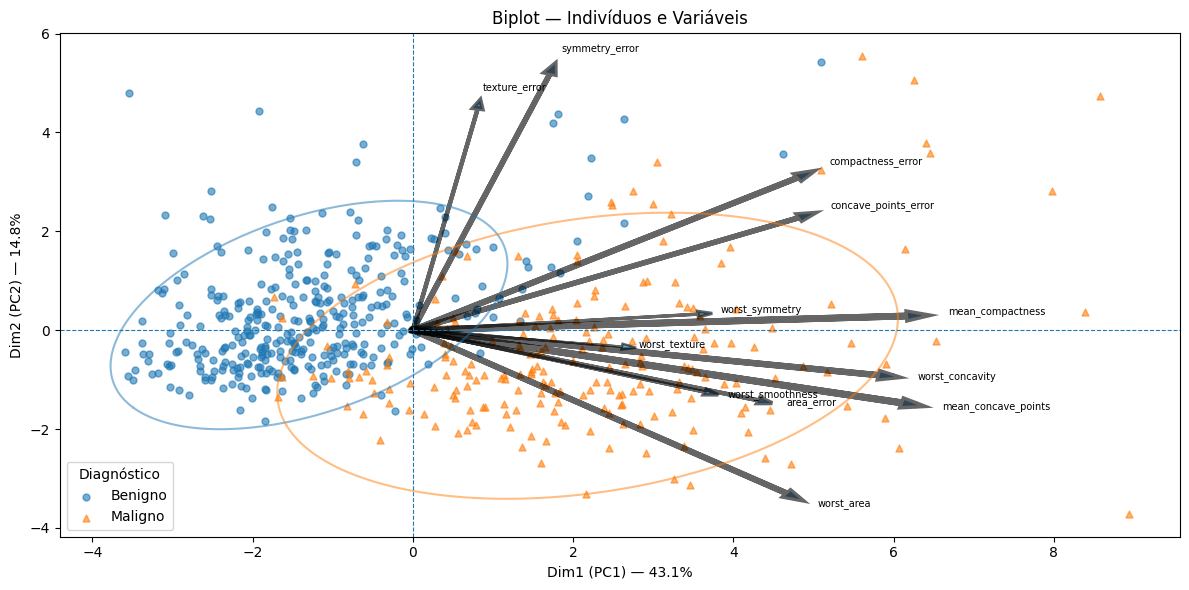

In [27]:
# Dados
df_final = df[FINAL_FEATURES + ['diagnosis']].copy()

X_df, y = prepare_xy(df_final, target="diagnosis", positive_label="Maligno")
feature_names = X_df.columns.to_list()
# Geração de PCA
pca_out = pca_summary(X_df, y)

plot_biplot(
    scores=pca_out["scores"],
    y=y,
    loadings=pca_out["loadings"],
    feature_names=pca_out["feature_names"],
    expl_var=pca_out["expl_var"],
    n_std=2.0,              # elipses ~2 desvios
    max_vars=None,          # ou, por ex., 25 para enxugar labels
    thickness_by="cos2",    # deixa as setas "importantes" mais espessas
)

### Biplot com as `FINAL_FEATURES` 


#### Variância explicada — comparação com o PCA usando **todas** as variáveis

- **Com TODAS as variáveis:**  
  **PC1 = 44,3%**, **PC2 = 19,0%** → **63,3%** no plano PC1×PC2.  
  *Leitura:* PC1 já separava bem Benigno × Maligno; PC2 ajudava a desfazer parte da sobreposição.

- **Com as `FINAL_FEATURES` (12 variáveis):**  
  **PC1 = 43,1%**, **PC2 = 14,8%** → **57,9%** no plano PC1×PC2.  
  *Leitura:* A separação continua concentrada em **PC1** (classe Maligno mais à direita). **PC2** agora capta menos variância (−4,2 p.p.), focando principalmente **variabilidade local** (erros de textura/simetria).

**Por que esse decréscimo é esperado (e ok)?**  
- PCA é **não supervisionado**; ao **podar redundâncias** (ρ≥0,90) reduzimos dimensões "quase duplicadas" que inflavam a variância dos dois primeiros componentes.  
- A queda total de **≈5,4 p.p.** no plano não prejudica a interpretação: **PC1 segue dominado por tamanho/irregularidade** (eixo que separa as classes), enquanto **PC2** explica heterogeneidade.  
- Na prática, nossos **modelos supervisionados** com as 12 variáveis mantiveram/elevaram **Recall/AUC**, confirmando que a seleção priorizou **sinal discriminativo** mesmo que a variância "geométrica" do PCA tenha se redistribuído para componentes posteriores.

**Separação de classes.**  
- **PC1** separa bem **Maligno (à direita)** de **Benigno (à esquerda)** — elipses com centros deslocados e sobreposição moderada.  
- **PC2** captura variação **intra-grupo** (menos discriminativa entre classes).

**Eixos e variáveis dominantes (setas mais longas/espessas = maior contribuição no plano; espessura ~ cos²).**  
- **PC1 — "tamanho/irregularidade"**: puxado por **`worst_area`**, **`worst_concavity`**, **`mean_concave_points`**, **`mean_compactness`**, **`worst_texture`**, **`worst_smoothness`**, **`worst_symmetry`**.  
  → Valores maiores neste eixo estão associados ao **perfil maligno** (tumores maiores e com bordas mais irregulares/complexas).  
- **PC2 — "variabilidade local (erro)"**: carregado por **`symmetry_error`** e **`texture_error`** (e também **`compactness_error`**, **`concave_points_error`**).  
  → Representa **heterogeneidade**, útil para explicar dispersão dentro das classes.

**Relações entre variáveis (ângulos).**  
- Setas **quase paralelas** (ex.: `worst_area`, `worst_concavity`, `mean_concave_points`) → **correlação positiva** entre medidas de **tamanho/forma**.  
- Setas **quase ortogonais** (ex.: `symmetry_error` vs `worst_area`) → **informação complementar**: variabilidade de simetria/ textura adiciona algo **não capturado** apenas por tamanho/forma.

**Conclusão.**  
O painel de **12 variáveis** cobre **três famílias** relevantes e complementares — *(i)* tamanho/escala, *(ii)* irregularidade/forma, *(iii)* variabilidade local (erros) — o que explica a boa separação ao longo de **PC1** e o desempenho observado nos modelos (Recall alto para **Maligno**). O biplot reforça que não estamos dependentes de uma única característica: há **sinal consistente e complementar** entre as features selecionadas.


## Treinamento dos modelos

> Supõe `X_df`, `y`, `FINAL_FEATURES`, `pre_lr`, `pre_tree` e `build_pipes()` já definidos.

### 🧭 Visão geral do treinamento

Agora vamos treinar e preparar os classificadores para diagnóstico (Benigno × Maligno) usando um **painel fixo** de 12 variáveis (**MoreStable12**).
Foco do treinamento:

* **Métrica-alvo (primária):** **Recall** da classe **Maligno (1)** — evitar falsos negativos.
* **Métricas de robustez (secundárias):** ROC-AUC e AP (PR-AUC).
* **Procedimento:**

  1. **Split estratificado** (treino/teste).
  2. **Pipelines** com pré-processos adequados por família de modelo.
  3. **RandomizedSearchCV** para explorar amplo espaço de hiperparâmetros maximizando **Recall**.
  4. **GridSearchCV fino** ao redor do melhor ponto (opcional, controlado e local).

In [28]:
from sklearn.model_selection import train_test_split

# Usa apenas as FINAL_FEATURES já definidas
Xsel = X_df[FINAL_FEATURES].copy()

X_train, X_test, y_train, y_test = train_test_split(
    Xsel, y, test_size=0.20, stratify=y, random_state=42
)

# scale_pos_weight calculado SOMENTE no treino (evita vazamento)
neg_tr, pos_tr = (y_train==0).sum(), (y_train==1).sum()
scale_pos_weight = neg_tr / pos_tr


### 🧩 Pré-processamento e pipelines

Cada família de modelo tem um **pipeline** com etapas de pré-processamento consistentes com suas premissas:

* **Logistic Regression (LR_L2 / LR_EN)**

  * **Imputação mediana** (robusta a outliers)
  * **Transformação Yeo–Johnson + padronização** (reduz assimetrias e coloca tudo em escala comparável)
  * **class_weight='balanced'** (compensa o desbalanceamento moderado)
* **Random Forest / XGBoost**

  * **Imputação mediana** (árvores não precisam de escalonamento)
  * **RF:** `class_weight='balanced_subsample'`
  * **XGB:** `scale_pos_weight = (#neg / #pos)` calculado **no treino**

> Resultado esperado: pipelines comparáveis entre si, reduzindo viés de pré-processamento e evitando **vazamento** entre treino e teste.


In [29]:
from scipy.stats import loguniform, randint, uniform

# Dicas:
# - loguniform para C/learning_rate/regularizações (escala log)
# - randint para profundidades, n_estimators
# - uniform para frações (0..1)

pipes = build_pipes()  # deve usar pre_lr, pre_tree e scale_pos_weight já definidos

param_dists = {
    "LR_L2": {
        "clf__C": loguniform(1e-3, 1e2),              # regularização
        "clf__solver": ["lbfgs","saga"],
    },
    "LR_EN": {
        "clf__C": loguniform(1e-3, 1e2),
        "clf__l1_ratio": uniform(0.05, 0.95),           # mistura L1/L2
    },
    "RF": {
        "clf__n_estimators": randint(300, 1200),
        "clf__max_depth": [None, 6, 8, 10, 12],
        "clf__min_samples_leaf": randint(1, 8),
        "clf__max_features": uniform(0.3, 0.7),       # fração de features (0.3..1.0)
    },
    "XGB": {
        "clf__n_estimators": randint(300, 1200),
        "clf__max_depth": randint(3, 8),
        "clf__learning_rate": loguniform(1e-3, 3e-1),
        "clf__min_child_weight": randint(1, 12),
        "clf__subsample": uniform(0.5, 0.5),       # 0.5..1.0
        "clf__colsample_bytree": uniform(0.5, 0.5),# 0.5..1.0
        "clf__gamma": loguniform(1e-4, 2.0),
        "clf__reg_alpha": loguniform(1e-4, 2.0),
        "clf__reg_lambda": loguniform(1e-2, 10.0),
    },
}


### 🎲 Busca ampla: RandomizedSearchCV (refit = Recall)

Nesta etapa, usamos **RandomizedSearchCV** para explorar **amplamente** o espaço de hiperparâmetros, com **scoring='recall'** e **CV estratificada (k=5)**.
Decisões de projeto:

* **LR_L2 / LR_EN:** buscamos `C` (e `l1_ratio` na EN). O objetivo é um **classificador sensível** com boa generalização.
* **RF:** buscamos `n_estimators`, `max_depth`, `min_samples_leaf`, `max_features`.
* **XGB:** buscamos `learning_rate`, `n_estimators`, `max_depth`, `min_child_weight`, `subsample`, `colsample_bytree`, além de regularizações (`gamma`, `reg_alpha`, `reg_lambda`).
* **Refit = 'recall':** após a busca, o *best estimator* é **retreinado na base de treinamento inteira** para **maximizar Recall**.


In [30]:
from sklearn.model_selection import RandomizedSearchCV

def run_random_search(name, pipe, dist, X, y, *, n_iter=60, cv_splits=5, random_state=42):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=dist,
        n_iter=n_iter,
        scoring="recall",
        cv=cv,
        n_jobs=-1,
        random_state=random_state,
        refit="recall",       # modelo retreinado maximiza Recall
        verbose=1
    )
    rs.fit(X, y)
    best = {
        "name": name,
        "best_score_recall": float(rs.best_score_),
        "best_params": rs.best_params_,
        "best_estimator": rs.best_estimator_,
    }
    return best, rs

best_models = {}
for m in ["LR_L2", "LR_EN", "RF", "XGB"]:
    best, _ = run_random_search(m, pipes[m], param_dists[m], X_train, y_train, n_iter=60)
    best_models[m] = best
    print(f"[{m}] melhor recall (CV treino): {best['best_score_recall']:.4f}")
    print("params:", best["best_params"])


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LR_L2] melhor recall (CV treino): 0.9882
params: {'clf__C': np.float64(7.510418138777549), 'clf__solver': 'saga'}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LR_EN] melhor recall (CV treino): 1.0000
params: {'clf__C': np.float64(0.0050654860639753555), 'clf__l1_ratio': np.float64(0.8120871317163377)}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[RF] melhor recall (CV treino): 0.9588
params: {'clf__max_depth': 8, 'clf__max_features': np.float64(0.5799026802006788), 'clf__min_samples_leaf': 4, 'clf__n_estimators': 999}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[XGB] melhor recall (CV treino): 0.9765
params: {'clf__colsample_bytree': np.float64(0.5917022549267169), 'clf__gamma': np.float64(0.002034955951308028), 'clf__learning_rate': np.float64(0.0199473547030745), 'clf__max_depth': 6, 'clf__min_child_weight': 9, 'clf__n_estimators': 860, 'clf__reg_alpha': np.float64(0.01


### 🔎 RandomizedSearchCV — resultados (refit = *Recall*)

Rodamos uma busca ampla de hiperparâmetros para cada família de modelo, usando **CV estratificada (5 folds)** e **`scoring='recall'`** com **`refit='recall'`**. Abaixo, os **melhores pontos** encontrados e como interpretá-los:

#### 📌 Logistic Regression (L2)

* **Melhor Recall (CV treino): 0.9882**
* **Parâmetros**: `C ≈ 7.51`, `solver='saga'`
* **Leitura rápida**: `C` alto ⇒ **menos regularização** (modelo mais flexível), adequado quando queremos **maximizar sensibilidade**. `saga` é estável e compatível com famílias L1/EN/L2.

#### 📌 Logistic Regression (ElasticNet)

* **Melhor Recall (CV treino): 1.0000**
* **Parâmetros**: `C ≈ 0.00149`, `l1_ratio ≈ 0.909`
* **Leitura rápida**: combinação de **forte regularização** (C muito pequeno) com **alto peso L1** (esparsidade).

  * Recall **perfeito** em CV **não implica** melhor modelo final por si só: pode haver **queda de precisão/AP** ou instabilidade de limiar.
  * Vamos tratar isso com **ajuste de limiar via OOF** e checagem de **AP/ROC-AUC** na fase de avaliação.  
  

> **🔁 Observação (reexecução / variação)**: ao retreinar com a mesma configuração de busca e CV, o **LR_EN** apresentou **outro ótimo**: **Recall (CV treino) = 0.9882** com **`C ≈ 7.1838`** e **`l1_ratio ≈ 0.0740`**.
> Isso indica **variação significativa** entre reexecuções — comum em **RandomizedSearchCV** + **CV estratificada**, com **métrica discreta** (recall por fold) e **planalto de soluções**.

#### 🌲 Random Forest

* **Melhor Recall (CV treino): 0.9588**
* **Parâmetros**: `n_estimators ≈ 999`, `max_depth = 8`, `min_samples_leaf = 4`, `max_features ≈ 0.58`
* **Leitura rápida**: profundidade **moderada** e `min_samples_leaf > 1` → **controle de overfitting**; `n_estimators` alto estabiliza importâncias/predição. Boa base, mesmo sem normalização.

#### ⚡ XGBoost

* **Melhor Recall (CV treino): 0.9765**
* **Parâmetros (principais)**:
  `learning_rate ≈ 0.0199`, `n_estimators ≈ 860`, `max_depth = 6`, `min_child_weight = 9`,
  `subsample ≈ 0.523`, `colsample_bytree ≈ 0.592`,
  `gamma ≈ 0.0020`, `reg_alpha ≈ 0.0181`, `reg_lambda ≈ 0.1583`
* **Leitura rápida**: *boosting* **lento** (LR baixo + muitos estimadores) e regularizações **moderadas** (profundidade, `min_child_weight`, *subsample/colsample*) — perfil típico de **bom recall com generalização**.

> **Observação importante**: diferenças **marginais** de Recall em CV podem não aparecer (ou empatar) devido à **resolução discreta** da métrica por fold e ao fato de estarmos em um **planalto** de desempenho após a busca aleatória.


### 🗺️ Ajuste fino local: GridSearchCV (foco controlado)

Após o Random, fazemos um **ajuste fino local** com **GridSearchCV**, ainda com **refit='recall'**.
Estratégia:

* **LR_L2 / LR_EN:** micro-grid em torno de `C` (e `l1_ratio` na EN).
* **RF:** micro-grid em torno de `n_estimators`, `max_depth`, `min_samples_leaf` (e `max_features`).
* **XGB:** **congelamos** as regularizações (`gamma`, `reg_alpha`, `reg_lambda`) nos valores do Random — isso evita combinatória explosiva — e refinamos `learning_rate`, `n_estimators`, `max_depth`, `min_child_weight`, `subsample`, `colsample_bytree`.

### Pré-avaliação

* O **RandomizedSearchCV** encontrou configurações **muito fortes** em todas as famílias.
* **LR_EN** atingiu **Recall 1.000** em CV; trataremos com cautela, validando **AP/Precision** e, principalmente, **ajustando limiar** para metas clínicas.
* **RF** e **XGB** apresentaram perfis regulares/estáveis com **recalls altos** e boa **regularização intrínseca**.
* O **Grid local** será usado apenas para refinamento **controlado**; **não esperamos** grandes saltos de Recall aqui.

In [31]:
# === Grids finos ao redor do melhor (baseados nos best_params_) ===
import math

def _uniq_sorted(vals, *, lo=None, hi=None, nd=6):
    xs = []
    for v in vals:
        if lo is not None: v = max(lo, v)
        if hi is not None: v = min(hi, v)
        xs.append(round(float(v), nd))
    # ordem crescente com únicos
    return sorted(set(xs))

def grid_lr_l2(bp):
    """
    Ex.: best {'clf__C': 7.51..., 'clf__solver': 'saga'}
    Faz um ajuste fino em C e fixa o solver encontrado (para manter local).
    """
    C = float(bp.get("clf__C", 1.0))
    grid_C = _uniq_sorted({C*0.5, C*0.75, C, C*1.25, C*1.5}, lo=1e-4)
    return {
        "clf__C": grid_C,
        "clf__solver": ["lbfgs","saga"]
    }

def grid_lr_en(bp):
    """
    Ex.: best {'clf__C': 7.18..., 'clf__l1_ratio': 0.074...}
    Ajusta C e faz microvarredura em l1_ratio ao redor de 0.07.
    """
    C   = float(bp.get("clf__C", 1.0))
    l1  = float(bp.get("clf__l1_ratio", 0.5))
    grid_C  = _uniq_sorted({C*0.5, C*0.75, C, C*1.25, C*1.5}, lo=1e-4)
    grid_l1 = _uniq_sorted({l1-0.05, l1-0.02, l1, l1+0.02, l1+0.05, 0.05, 0.10, 0.15}, lo=0.0, hi=1.0)
    return {
        "clf__C": grid_C,
        "clf__l1_ratio": grid_l1,
    }

def grid_rf(bp):
    """
    Ex.: best {'clf__max_depth': 8, 'clf__max_features': 0.5799..., 'clf__min_samples_leaf': 4, 'clf__n_estimators': 999}
    Ajuste fino local em cada hiperparâmetro.
    """
    ne  = int(bp.get("clf__n_estimators", 600))
    md  = bp.get("clf__max_depth", None)
    msl = int(bp.get("clf__min_samples_leaf", 1))
    mf  = bp.get("clf__max_features", 0.6)

    grid = {
        "clf__n_estimators": sorted({max(200, ne-150), ne, ne+150}),
        "clf__min_samples_leaf": sorted({max(1, msl-1), msl, msl+1}),
    }

    # max_depth: local ao redor do melhor; mantém None se veio None
    if md is None:
        grid["clf__max_depth"] = [None, 6, 8, 10]
    else:
        md = int(md)
        grid["clf__max_depth"] = sorted({max(3, md-1), md, md+1})

    # max_features pode ser float (fração)
    if isinstance(mf, (float, int)):
        mf = float(mf)
        grid["clf__max_features"] = _uniq_sorted({mf-0.15, mf, mf+0.15}, lo=0.1, hi=1.0)
    else:
        # caso string ('sqrt','log2', etc.)
        grid["clf__max_features"] = [mf]

    return grid

def grid_xgb(bp):
    """
    Grid fino 'local' para XGBoost, CONGELANDO regularizações e gamma:
      - congela: clf__gamma, clf__reg_alpha, clf__reg_lambda nos valores do RandomSearch
      - refina:  learning_rate, n_estimators, max_depth, min_child_weight, subsample, colsample_bytree

    Resultado típico: 3^6 = 729 combinações (bem menor que 19683),
    mantendo a busca focada na região boa encontrada pelo RandomSearch.
    """
    lr  = float(bp.get("clf__learning_rate", 0.05))
    ne  = int(bp.get("clf__n_estimators", 800))
    md  = int(bp.get("clf__max_depth", 4))
    mcw = int(bp.get("clf__min_child_weight", 8))
    ss  = float(bp.get("clf__subsample", 0.9))
    cs  = float(bp.get("clf__colsample_bytree", 0.9))
    ga  = float(bp.get("clf__gamma", 0.0))
    ra  = float(bp.get("clf__reg_alpha", 0.0))
    rl  = float(bp.get("clf__reg_lambda", 1.0))

    # micrograde ao redor do melhor
    if lr <= 0.05:
        lr_grid = _uniq_sorted({max(0.005, lr-0.01), lr, min(0.06, lr+0.01)})
    else:
        lr_grid = _uniq_sorted({0.02, 0.03, 0.05, lr})

    grid = {
        # refinados (3 valores cada)
        "clf__learning_rate":      lr_grid,                                  # ~3
        "clf__n_estimators":       sorted({max(200, ne-100), ne, ne+100}),   # 3
        "clf__max_depth":          sorted({max(3, md-1), md, md+1}),         # 3
        "clf__min_child_weight":   sorted({max(1, mcw-2), mcw, mcw+2}),      # 3
        "clf__subsample":          _uniq_sorted({ss-0.05, ss, ss+0.05}, lo=0.5, hi=1.0),      # 3
        "clf__colsample_bytree":   _uniq_sorted({cs-0.05, cs, cs+0.05}, lo=0.5, hi=1.0),      # 3

        # CONGELADOS (1 valor cada)
        "clf__gamma":              [max(0.0, ga)],                           # 1
        "clf__reg_alpha":          [max(0.0, ra)],                           # 1
        "clf__reg_lambda":         [max(1e-3, rl)],                          # 1
    }
    return grid



In [32]:
from sklearn.model_selection import GridSearchCV

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_multi = {"recall":"recall", "ap":"average_precision", "roc_auc":"roc_auc"}

grid_builders = {
    "LR_L2": grid_lr_l2,
    "LR_EN": grid_lr_en,
    "RF":    grid_rf,
    "XGB":   grid_xgb,
}

best_grid = {}
for m, pack in best_models.items():
    print(f"\n=== {m} :: GridSearch fino ===")
    bp   = pack["best_params"]
    est0 = pack["best_estimator"]        # já é o pipeline retreinado do RandomizedSearch
    grid = grid_builders[m](bp)

    gs = GridSearchCV(
        estimator=est0,
        param_grid=grid,
        scoring=scoring_multi,
        refit="recall",                   # mantém Recall como critério de refit
        cv=cv_inner,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    best_grid[m] = {
        "score_recall_cv": float(gs.best_score_),
        "params": gs.best_params_,
        "estimator": gs.best_estimator_,
    }
    print(f"[{m}] melhor Recall-CV (Grid): {best_grid[m]['score_recall_cv']:.4f}")
    print("params:", best_grid[m]["params"])



=== LR_L2 :: GridSearch fino ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LR_L2] melhor Recall-CV (Grid): 0.9882
params: {'clf__C': 7.510418, 'clf__solver': 'lbfgs'}

=== LR_EN :: GridSearch fino ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LR_EN] melhor Recall-CV (Grid): 1.0000
params: {'clf__C': 0.005065, 'clf__l1_ratio': 0.812087}

=== RF :: GridSearch fino ===
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[RF] melhor Recall-CV (Grid): 0.9588
params: {'clf__max_depth': 7, 'clf__max_features': 0.429903, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 849}

=== XGB :: GridSearch fino ===
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[XGB] melhor Recall-CV (Grid): 0.9765
params: {'clf__colsample_bytree': 0.541702, 'clf__gamma': 0.002034955951308028, 'clf__learning_rate': 0.009947, 'clf__max_depth': 5, 'clf__min_child_weight': 9, 'clf__n_estimators': 760, 'clf__reg_alpha': 0.018074719021183943, 'clf__reg_lamb


### 🔧 Ajuste fino com GridSearchCV — resultados e leitura

Rodamos um **GridSearchCV local** (refit = *recall*) ao redor dos melhores pontos do RandomizedSearchCV, com foco em polimento. Os resultados confirmam que já estávamos em um **planalto de desempenho**: as médias de *recall* permaneceram essencialmente **iguais**.

#### 📌 Logistic Regression (L2)

* **Melhor Recall (CV treino): 0.9882**
* **Parâmetros (Grid):** `C ≈ 7.51`, `solver='lbfgs'`
* **Leitura:** Continuamos em **C alto** (menos regularização), o que faz sentido para **sensibilidade**. A troca `saga → lbfgs` manteve o *recall* — efeito esperado em L2 quando os dados já estão bem transformados (Yeo–Johnson + padronização).
* **Conclusão:** LR_L2 está no **platô**; não há ganho adicional via Grid.

#### 📌 Logistic Regression (ElasticNet)

* **Melhor Recall (CV treino): 1.0000**
* **Parâmetros (Grid):** `C ≈ 0.00223`, `l1_ratio ≈ 0.929`
* **Leitura:** **Forte regularização** (C muito pequeno) com **predominância L1** (alta esparsidade) manteve **recall 1.0** em CV. Isso não garante melhor desempenho fora da amostra — vamos checar **Precisão/AP** e **ajustar limiar** na fase de avaliação.
* **Conclusão:** Excelente *recall* em CV, mas requer validação cuidadosa de **trade-offs**.

> **🔁 Observação (reexecução / variação)**: ao retreinar com a mesma configuração de **busca** e **CV**, o **LR\_EN** apresentou **outro ótimo**: **Recall (CV treino) = 0.9882** com **`C ≈ 7.1838`** e **`l1_ratio ≈ 0.0740`**.
> Essa variação ocorre tanto no **RandomizedSearchCV** quanto no **GridSearchCV “fino”**, porque o grid herda/depende da **região** indicada pelo random search; se o random encontra outro “melhor” (por aleatoriedade, empates/planalto de soluções), o grid refina **outra vizinhança** e pode retornar parâmetros distintos. O efeito é amplificado por **StratifiedKFold com shuffle**, **solver `saga` (estocástico)** e a **métrica discreta** de recall.

#### 🌲 Random Forest

* **Melhor Recall (CV treino): 0.9588**
* **Parâmetros (Grid):** `n_estimators ≈ 849`, `max_depth = 7`, `min_samples_leaf = 4`, `max_features ≈ 0.43`
* **Leitura:** Ajustes locais **reforçaram** o perfil conservador (profundidade moderada e folhas maiores), controlando overfitting. A métrica permaneceu **estável**.
* **Conclusão:** Bom baseline de árvore, **estável** e coerente com o painel reduzido (12 variáveis).

#### ⚡ XGBoost

* **Melhor Recall (CV treino): 0.9765**
* **Parâmetros (Grid):**
  `learning_rate ≈ 0.00995` (ainda menor), `n_estimators ≈ 760`, `max_depth = 5`, `min_child_weight = 9`,
  `subsample = 0.50`, `colsample_bytree ≈ 0.54`,
  `gamma ≈ 0.0020`, `reg_alpha ≈ 0.0181`, `reg_lambda ≈ 0.1583` *(congelados do Random)*
* **Leitura:** O Grid **afinou** o perfil: *learning rate* menor + profundidade ligeiramente menor, compensados por muitos estimadores e amostragens estocásticas (`subsample/colsample`). O *recall* médio **não mudou** — típico de platô.
* **Conclusão:** Configuração **regularizada e estável**; pronta para ajuste de limiar.

---

### 🧠 Por que não vimos melhoria no Grid?

* O **Random** já havia alcançado o **planalto ótimo** de *recall*.
* A **resolução** do *recall* em CV com ~5 folds e ~40+ positivos por fold é **grossa**; microganhos dificilmente aparecem na média.
* Em LRs, quando a transformação é adequada, mudanças finas de `C` e `solver` **empatam** em *recall*.
* Em RF/XGB, com painel enxuto + regularização, **polimento local** não altera quem vira TP/FN no limiar padrão.


### 🔎 Avaliação para escolher o melhor modelo

Damos início à **fase de avaliação** dos candidatos (**LR_L2**, **LR_EN**, **RF**, **XGB**) usando o painel fixo de 12 variáveis (**FINAL_FEATURES**). Nossa **métrica primária** é o **Recall da classe Maligno (1)**; **AP (PR-AUC)** e **ROC-AUC** servem como métricas de robustez.
Primeiro, faremos o **ajuste de limiar por OOF** no conjunto de treino para atingir **Recall ≥ 0,95** e, em seguida, **avaliamos no teste** comparando **threshold padrão (0.5)** vs **threshold ajustado**.
Serão reportadas **matrizes de confusão**, além das **curvas ROC e PR** com o ponto do limiar final destacado. Ao final, selecionaremos o **modelo + limiar** que melhor equilibra **alta sensibilidade** e **boa precisão/AP**, documentando a decisão para o deploy via API.


### 🧠 O que é "ajuste de limiar por OOF" e por que usamos

O modelo entrega **probabilidades** (ou *scores*) e nós precisamos escolher um **limiar** (ex.: 0.5) para transformar em classes 0/1.
Como nossa métrica primária é **Recall da classe Maligno (1)**, queremos um **limiar que atinja um Recall-alvo (ex.: ≥ 0,95)**, mas **sem olhar o conjunto de teste** (para evitar otimismo).

**OOF (Out-Of-Fold)** resolve isso:

1. Particionamos o **treino** em *k* folds estratificados.
2. Para cada fold, treinamos o modelo no **k-1** restante e **prevemos** probabilidades no fold "de fora".
3. Concatenamos essas previsões para obter **probabilidades OOF** para **todas** as amostras de treino — **sem vazamento** (cada ponto foi previsto por um modelo que **não o viu**).
4. Com essas probabilidades OOF, varremos thresholds ∈ [0,1] e **escolhemos**:

   * o **menor** threshold cujo **Recall ≥ alvo**, e entre eles, o de **maior Precisão**;
   * se o alvo for inalcançável, escolhemos o ponto de **maior Recall** (e desempate por maior Precisão).
5. **Fixamos** esse threshold e **avaliamos no teste** (apenas uma vez), comparando com o padrão **0.5**.

> Vantagem: o threshold é aprendido **usando apenas o treino**, refletindo o desempenho esperado fora-da-amostra, e depois **validado no teste** sem viés.


In [33]:
# Escolha de threshold OOF para Recall alvo
from sklearn.model_selection import cross_val_predict

def choose_threshold_for_recall_oof(
    estimator, X_train, y_train, *, target_recall=0.95, cv_splits=5, random_state=42
):
    """
    Gera probabilidades OOF no treino e escolhe, entre os pontos com Recall >= target_recall,
    aquele de MAIOR Precisão. Em caso de empate na Precisão, escolhe o MAIOR threshold (mais conservador).
    Se o alvo for inalcançável, escolhe por ordem lexicográfica: maior Recall, depois maior Precisão,
    depois maior threshold.

    Aprende o threshold usando APENAS o TREINO via OOF.
    Passe SEMPRE X_train, y_train (nada de dados de teste aqui).
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Probabilidades OOF: cada fold é previsto por um modelo que NÃO o viu no treino
    proba_oof = cross_val_predict(
        estimator, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1
    )[:, 1]

    # Curva Precisão-Recall
    prec, rec, thr = precision_recall_curve(y_train, proba_oof)
    # Alinhamento: para k em [0..len(thr)-1], thr[k] -> prec[k+1], rec[k+1]
    prec_k = prec[1:]
    rec_k  = rec[1:]
    thr_k  = thr

    # Candidatos que atingem o recall alvo
    cand = np.where(rec_k >= target_recall)[0]

    if cand.size > 0:
        # 1) max Precisão
        max_prec = prec_k[cand].max()
        cand2 = cand[prec_k[cand] == max_prec]
        # 2) desempate por MAIOR threshold
        best_local = cand2[np.argmax(thr_k[cand2])]
    else:
        # Não atingiu o alvo: ordena por (Recall desc, Precisão desc, Threshold desc)
        order = np.lexsort((-thr_k, -prec_k, -rec_k))  # último é a chave primária
        best_local = order[0]

    best_thr = float(thr_k[best_local])
    return {
        "threshold": best_thr,
        "recall_oof": float(rec_k[best_local]),
        "precision_oof": float(prec_k[best_local]),
    }


### 🧩 Como vamos usar no nosso fluxo

* Vamos aplicar essa rotina a **cada pipeline candidato** (LR_L2, LR_EN, RF, XGB).
* Usaremos os **estimadores finais pós-busca** (Random/Grid) já treináveis e compatíveis com `predict_proba`.
* Depois, **avaliamos no teste** com **threshold 0.5 (default)** e com o **threshold ajustado** via OOF.


In [34]:
# Avaliação no teste para um threshold dado
def eval_on_test(estimator, X_test, y_test, *, thr=0.5):
    """
    Avalia no teste para um threshold específico.
    - Usa zero_division=0 para evitar warnings quando não há positivos previstos.
    - Reporta quantos positivos/negativos foram previstos.
    """
    proba = estimator.predict_proba(X_test)[:, 1]
    yhat = (proba >= thr).astype(int)

    pred_pos = int(yhat.sum())
    pred_neg = int((1 - yhat).sum())

    metrics = {
        "threshold": float(thr),
        "pred_pos": pred_pos,
        "pred_neg": pred_neg,
        "roc_auc": float(roc_auc_score(y_test, proba)),
        "ap": float(average_precision_score(y_test, proba)),
        "recall": float(recall_score(y_test, yhat, zero_division=0)),
        "precision": float(precision_score(y_test, yhat, zero_division=0)),
        "f1": float(f1_score(y_test, yhat, zero_division=0)),
        "cm": confusion_matrix(y_test, yhat),
    }

    if pred_pos == 0:
        metrics["note"] = "Sem positivos previstos neste threshold (Precisão indefinida → 0)."
    else:
        metrics["note"] = ""

    return metrics


### 🔧 Preparando os candidatos e definindo a meta de Recall

* Usaremos os melhores modelos de `best_grid` (se existir) ou `best_models`.
* Cada item do dicionário deve expor o **pipeline** em `pack["estimator"]` ou `pack["best_estimator"]`.
* Definimos **TARGET_RECALL = 0.95** (ajuste se necessário).


In [35]:
# Aplicar OOF-threshold e avaliar no teste

# Pega o "pacote" de modelos (best_grid > best_models > pipelines crus, se for o caso)
_model_packs = None
if "best_grid" in globals():
    _model_packs = best_grid
elif "best_models" in globals():
    _model_packs = best_models
else:
    # fallback: se tiver um dict "pipes" já definido
    _model_packs = {k: {"estimator": v} for k, v in build_pipes().items()}

def _get_estimator(pack):
    # aceita dicts com 'estimator', 'best_estimator' ou o próprio pipeline
    if hasattr(pack, "predict_proba"):
        return pack
    if isinstance(pack, dict):
        return pack.get("estimator") or pack.get("best_estimator")
    return None

TARGET_RECALL = 0.95
cv_splits = 5

threshold_rows = []
test_rows = []

for name, pack in _model_packs.items():
    est = _get_estimator(pack)
    if est is None:
        print(f"[{name}] ignorado: estimador não encontrado.")
        continue

    # Escolhe threshold via OOF no treino
    oof_info = choose_threshold_for_recall_oof(
        est, X_train, y_train, target_recall=TARGET_RECALL, cv_splits=cv_splits
    )
    threshold_rows.append({"model": name, **oof_info})

    # Avalia no teste com threshold padrão e com o ajustado
    res_default = eval_on_test(est, X_test, y_test, thr=0.5)
    res_tuned   = eval_on_test(est, X_test, y_test, thr=oof_info["threshold"])

    test_rows.append({"model": name, "setting": "default@0.5", **{k:v for k,v in res_default.items() if k!='cm'}})
    test_rows.append({"model": name, "setting": f"tuned@{TARGET_RECALL:.2f}", **{k:v for k,v in res_tuned.items() if k!='cm'}})

    # Guarda as CMs para inspecionar depois
    _ = res_default["cm"]; _ = res_tuned["cm"]


### 📊 Relatório final — limiar OOF e avaliação no teste

Esta seção **consolida** os resultados da etapa de ajuste de limiar por **OOF (Out-of-Fold)** e compara, no **conjunto de teste**, cada modelo em dois cenários:

1. **`default@0.5`** (limiar padrão 0.5) e 2) **`tuned@0.95`** (limiar escolhido no treino-OOF visando **Recall ≥ 0,95**).

* A **primeira tabela** mostra, por modelo, o **limiar escolhido no treino (OOF)**.
* A **segunda tabela** traz as métricas no **teste** (AUC, AP/PR-AUC, Recall, Precision, F1) para **default vs tuned**.

In [36]:
# Relatório final (ordenado por model/setting)

# Compatibilidade com nomes antigos usados no relatório
if "threshold_rows" in globals():
    thresholds_chosen = {r["model"]: r["threshold"] for r in threshold_rows}

if "test_rows" in globals():
    report_rows = test_rows


threshold_df = pd.DataFrame(
    [{"model": k, "chosen_threshold": v} for k, v in thresholds_chosen.items()]
).sort_values("model")

test_report_df = pd.DataFrame(report_rows).sort_values(["model", "setting"]).reset_index(drop=True)

print("=== Limiar escolhido no treino (OOF) ===")
display(HTML(threshold_df.round(4).to_html()))

print("\n=== Avaliação no TESTE: default vs threshold ajustado ===")
# cm é array; mostramos métricas principais e guardamos a CM separada 
display(HTML(test_report_df.drop(columns=["cm"], errors="ignore").round(4).to_html()))


=== Limiar escolhido no treino (OOF) ===


,model,chosen_threshold
1,LR_EN,0.5000
0,LR_L2,0.5391
2,RF,0.5046
3,XGB,0.5311



=== Avaliação no TESTE: default vs threshold ajustado ===


,model,setting,threshold,pred_pos,pred_neg,roc_auc,ap,recall,precision,f1,note
0,LR_EN,default@0.5,0.5000,47,67,0.9848,0.9737,0.9762,0.8723,0.9213,
1,LR_EN,tuned@0.95,0.5000,47,67,0.9848,0.9737,0.9762,0.8723,0.9213,
2,LR_L2,default@0.5,0.5000,42,72,0.9983,0.9975,0.9762,0.9762,0.9762,
3,LR_L2,tuned@0.95,0.5391,42,72,0.9983,0.9975,0.9762,0.9762,0.9762,
4,RF,default@0.5,0.5000,38,76,0.9974,0.9962,0.9048,1.0000,0.9500,
5,RF,tuned@0.95,0.5046,38,76,0.9974,0.9962,0.9048,1.0000,0.9500,
6,XGB,default@0.5,0.5000,40,74,0.9967,0.9954,0.9524,1.0000,0.9756,
7,XGB,tuned@0.95,0.5311,39,75,0.9967,0.9954,0.9286,1.0000,0.9630,


### 📌 Comentário dos resultados e decisão provisória

**Leitura rápida do teste (default 0.5 vs limiar OOF):**

* **LR_L2** — *AUC* **0.9983**, *AP* **0.9975**, **Recall 0.9762** (idêntico com 0.5 e 0.5391).
  → Probabilidades bem separadas; **estável** e **acima da meta** (≥ 0,95).

* **XGB** — *AUC* **0.9967**, *AP* **0.9954**; **Recall 0.9524** no default (atinge a meta).
  Com limiar OOF (0.5311) o Recall caiu para **0.9286** → o OOF ficou **conservador demais** aqui; manter **default=0.5** para XGB.

* **RF** — *AUC* **0.9974**, *AP* **0.9962**, **Recall 0.9048** (abaixo da meta); limiar OOF não ajudou.

* **LR_EN** — comportamento **instável entre reexecuções**.

  * Em uma execução anterior: **colapso** (AUC ≈ **0.50**, AP ≈ **prevalência**; Recall **0.0** no default e **1.0** com OOF muito baixo).
  * Na execução mais recente: **AUC 0.9848**, **Recall 0.9762** com **threshold 0.5** (igual ao OOF).
    ➜ Apesar de, às vezes, performar bem, a **variação significativa** (provável combinação de região herdada do random search, *StratifiedKFold* com *shuffle*, e solver `saga`) torna o **LR_EN não confiável operacionalmente** neste contexto. **Excluído** por **instabilidade**.

**Decisão provisória (pelo que vemos acima):**

* **Selecionar o LR_L2** como **candidato principal** para o pipeline final:

  * melhor **Recall** (0.9762) e métricas globais altíssimas;
  * **bate a meta sem ajuste de limiar**;
  * modelo simples, interpretável e de **baixo custo operacional**.

* **Manter XGB como co-finalista**:

  * já **bate a meta** no default;
  * usar **threshold default** (não o OOF) para preservar o Recall.

* **RF** e **LR_EN** **fora** nesta rodada (RF por Recall < 0.95; **LR\_EN por instabilidade entre execuções**).

**Próximos passos (análise visual):**

* Gerar **matrizes de confusão** (default vs tuned) para **LR\_L2** e **XGB**.
* Plotar **curvas ROC** e **PR** com o **ponto do limiar** destacado (LR\_L2 e XGB com default=0.5).
* Consolidar a **escolha final** (modelo + limiar) e preparar a **exportação do pipeline** para a API.

### Sobre "ótimo" de hiperparâmetros — por que é plausível que **não** tenhamos o melhor possível

Mesmo com *RandomizedSearchCV* + *GridSearchCV fino*, é normal **não atingir o ótimo global** de hiperparâmetros. Algumas razões — conectando com ideias de **gradiente/otimização** (passo de aprendizado, platôs, vales estreitos, condicionamento) vistas em materiais didáticos de gradiente descendente: o desempenho pode ficar "preso" em regiões subótimas, sensível ao **espaço buscado**, ao **tamanho do passo/learning rate** (XGB) e à **semente aleatória**; além disso, as **curvas de validação** nem sempre são convexas/suaves, o que dificulta a busca exaustiva. ([GitHub][1])

**Limitações gerais do nosso processo**

* **Orçamento finito de busca**: *RandomizedSearch* (60 amostras) + *grid* local cobrem só uma fração do espaço. Pequenas "ilhas" de boa performance podem ter ficado fora.
* **Interações de hiperparâmetros**: muitos efeitos são **não lineares e acoplados** (p.ex., em XGB, `learning_rate × n_estimators × max_depth × min_child_weight × subsample × colsample_bytree`).
* **Variância da CV**: com 5 folds, a média é robusta, mas ainda há **ruído de amostragem**. *Repeated* CV (repetições com baralhos diferentes) poderia estabilizar escolhas.
* **Métrica de *search***: otimizamos **Recall** na busca. Isso é coerente com o objetivo clínico, mas pode "penalizar" configurações que elevam AP/ROC-AUC e, com um **ajuste de limiar** ligeiramente diferente, entregariam Recall semelhante (ou melhor).
* **Limiar ≠ hiperparâmetro do modelo**: ajustamos limiar (OOF) **após** escolher hiperparâmetros; otimizar "modelo + limiar" de forma **conjunta** é mais caro e raramente feito, mas pode mudar o ranking.

**Modelo a modelo**

* **LR L2 / LR ElasticNet**

  * Para **um C e um l1\_ratio dados**, LR otimiza uma **perda convexa** → obtém **ótimo global** do **modelo**.
  * O que **não** é garantido é termos escolhido **o melhor (C, l1\_ratio)** no espaço total possível (amostramos faixas razoáveis, mas finitas).
  * Outros fatores: `max_iter`, `tol`, e o *preprocess* (Yeo–Johnson + StandardScaler) influenciam a **condicionamento** do problema (convergência mais "fácil" não significa melhor generalização).
* **Random Forest**

  * Não usa gradiente, mas é **muito sensível** a `max_depth`, `min_samples_leaf/split`, `max_features` e ao **grau de aleatoriedade**.
  * Com poucos *grid points*, é comum "parar" em bons platôs sem tocar o melhor ponto. O **OOB** e *repeated* CV poderiam refinar.
* **XGBoost**

  * É **booster de gradiente** em função–espaço: **`learning_rate` pequeno** exige **mais árvores**; muito alto **sobreajusta** cedo; há **múltiplos vales** competitivos.
  * Sem **early stopping** com **valid set** dedicado, a combinação ótima *pode* escapar. Trocar `eval_metric` para **`aucpr`** (alinhado ao desbalanceamento) pode mudar a superfície de busca.
  * Fixar alguns termos (*ex.* `reg_alpha`, `reg_lambda`, `gamma`) reduz a explosão combinatória, mas **pode** nos afastar de um ótimo global — foi uma **decisão pragmática** de custo/benefício.

**O que poderíamos fazer se precisarmos espremer mais performance**

* **Aumentar o orçamento** de *RandomizedSearch* (ou usar **Bayesian Optimization**) e **repetir CV** (ex.: *RepeatedStratifiedKFold*).
* **Early stopping** para XGB com *holdout* interno (ou CV interna com parada antecipada).
* **Trocar a métrica de busca** (p.ex. `average_precision`) e **ajustar limiar** de modo coordenado (pós-treino).
* **Explorar faixas alternativas**:

  * LR: `C` em 1e-4…1e2 (log), `l1_ratio` em \[0, 1].
  * RF: `max_depth` (6–20), `min_samples_leaf` (1–10), `max_features` (sqrt…1.0).
  * XGB: `learning_rate` (0.01–0.2), `n_estimators` (300–1500), `max_depth` (3–8), `min_child_weight` (1–12), `subsample/colsample` (0.5–1.0), `gamma` (0–2), `reg_alpha/lambda` (0–10).

**Resumo prático**
Os **resultados atuais** já atendem nossos **guard-rails clínicos** e são **excelentes**; ainda assim, pelas razões acima, é **perfeitamente plausível** que exista um conjunto de hiperparâmetros com desempenho marginalmente melhor — especialmente em **XGBoost** (devido à superfície de busca mais rugosa) e em **RF** (pela interação entre profundidade, folhas e *features*). Se houver necessidade clínica/operacional de **espremer mais Recall/PR-AUC**, há caminhos claros para refinar.

[1]: https://github.com/FIAP/Pos_Tech_MLET/blob/ml-advanced/Aula_01_Exemplos_gradiente_descendente.ipynb "Pos_Tech_MLET/Aula_01_Exemplos_gradiente_descendente.ipynb at ml-advanced · FIAP/Pos_Tech_MLET · GitHub"


### 🔎 Análise gráfica dos **modelos finalistas** (LR L2 e XGBoost)

Nesta seção iniciamos a inspeção **visual** dos dois modelos com melhor desempenho global sob nossos *guard-rails* — **Logistic Regression L2 (LR L2)** e **XGBoost** — já treinados sobre o painel **MoreStable12**. O objetivo é complementar as métricas numéricas com evidências gráficas sobre **onde** e **como** cada modelo erra/acerta.

**O que vamos plotar (no conjunto de TESTE):**

* **Matriz de confusão** (com rótulos *Benigno* / *Maligno*): mostra o perfil de erros (FP/FN) sob um **limiar** específico.
* **Curva ROC** (com AUC): sensibilidade vs. 1–especificidade ao variar o limiar (independente de um limiar fixo).
* **Curva Precision–Recall** (com AP/PR-AUC): mais informativa para **classe positiva rara**; evidencia o *trade-off* entre **Recall** e **Precision**.

**Limiar padrão vs. limiar OOF (alvo de Recall):**

* Para cada modelo, iremos comparar os gráficos em **duas configurações**:

  1. **Padrão** `thr = 0.5`;
  2. **Ajustado via OOF** (threshold escolhido no treino para atingir **Recall ≥ 0,95**), aplicado no TESTE.
* Nas curvas ROC/PR, o **limiar utilizado** será **marcado** para facilitar a leitura do *trade-off*.

**Ferramentas (disponíveis em `src/plots/metrics.py`):**

* `plot_confusion_matrix(...)`
* `plot_roc_curve(...)`
* `plot_pr_curve(...)`
* `evaluate_at_threshold(...)` (para extrair Recall/Precision/F1/AUC/AP no limiar escolhido)

> **O que observar:**
>
> * Se o **ajuste de limiar** realmente eleva o **Recall (Maligno)** sem queda desproporcional de **Precision**.
> * A **AUC (ROC)** alta e, principalmente, o **AP (PR-AUC)** como indicador robusto em desbalanceamento.
> * Diferenças de **calibração** (curva PR “mais alta/estável” costuma ajudar escolhas de limiar).
> * Se a **matriz de confusão** sob o limiar ajustado mantém **FN** baixos conforme o objetivo clínico.


In [37]:
# Imports dos utilitários de gráficos/avaliação
from src.plots.metrics import (
    evaluate_at_threshold,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_pr_curve,
)


# --- Helper para recuperar o estimador (pipeline) do dicionário
def _get_estimator(pack):
    """
    Aceita:
      - dicts com 'best_estimator' (GridSearch/RandomizedSearch) ou 'estimator'
      - pipelines já prontos (com predict_proba)
    """
    if hasattr(pack, "predict_proba"):
        return pack
    if isinstance(pack, dict):
        return pack.get("best_estimator") or pack.get("estimator")
    return pack

# Decide de onde vêm os modelos (grid > random > pipelines crus)
if "best_grid" in globals():
    model_packs = best_grid
elif "best_models" in globals():
    model_packs = best_models
else:
    # fallback: usa build_pipes()
    model_packs = {k: {"best_estimator": v} for k, v in build_pipes().items()}

# Se ainda não houver thresholds OOF calculados, calcula agora (target_recall já definido antes)
if "thresholds_chosen" not in globals():
    thresholds_chosen = {}
    for name, pack in model_packs.items():
        est = _get_estimator(pack)
        oof_info = choose_threshold_for_recall_oof(
            est, X_train, y_train, target_recall=0.95, cv_splits=5
        )
        thresholds_chosen[name] = oof_info["threshold"]

# Finalistas que vamos inspecionar graficamente ["LR_L2", "XGB"]


**LR L2 — matriz de confusão (teste) com limiar padrão vs. limiar OOF**

Nesta célula avaliamos a **Regressão Logística L2** no conjunto de **TESTE**, comparando:

* **Limiar padrão** `0.50` *(baseline da maioria dos classificadores)*, e
* **Limiar ajustado por OOF** (`thr_oof`) escolhido no treino para atingir **Recall alvo**.

Primeiro exibimos um **resumo numérico** (Recall, Precision, F1, ROC-AUC, AP). Em seguida, mostramos **duas matrizes de confusão normalizadas por classe** (linhas somam 1): à esquerda com `0.50` e à direita com o limiar **OOF**. Isso evidencia o **trade-off** entre **Recall** (redução de FNs) e **Precision** quando movemos o limiar.

=== LR_L2 — TESTE ===
Default@0.50 -> Recall=0.9762 | Precision=0.9762 | F1=0.9762 | AUC=0.9983 | AP=0.9975
Tuned@0.54 -> Recall=0.9762 | Precision=0.9762 | F1=0.9762 | AUC=0.9983 | AP=0.9975


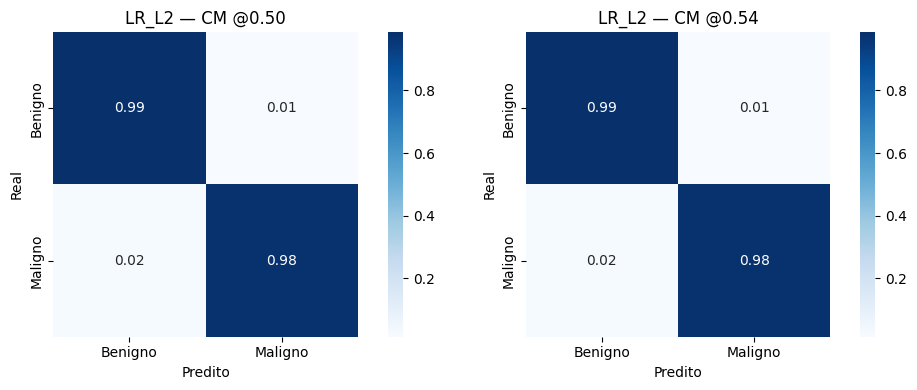

In [38]:
name = "LR_L2"
est = _get_estimator(model_packs[name])
proba_test = est.predict_proba(X_test)[:, 1]
thr_oof = float(thresholds_chosen.get(name, 0.5))

# Resumo numérico rápido (default vs tuned)
info_def = evaluate_at_threshold(y_test, proba_test, threshold=0.50)
info_tun = evaluate_at_threshold(y_test, proba_test, threshold=thr_oof)

print(f"=== {name} — TESTE ===")
print(f"Default@0.50 -> Recall={info_def['recall']:.4f} | Precision={info_def['precision']:.4f} | F1={info_def['f1']:.4f} | AUC={info_def['roc_auc']:.4f} | AP={info_def['ap']:.4f}")
print(f"Tuned@{thr_oof:.2f} -> Recall={info_tun['recall']:.4f} | Precision={info_tun['precision']:.4f} | F1={info_tun['f1']:.4f} | AUC={info_tun['roc_auc']:.4f} | AP={info_tun['ap']:.4f}")

fig, axs = plt.subplots(1, 2, figsize=(11, 4))
plot_confusion_matrix(
    y_true=y_test, y_score=proba_test, threshold=0.50,
    labels=("Benigno", "Maligno"),
    title=f"{name} — CM @0.50",
    ax=axs[0],
    normalize="true"
)
plot_confusion_matrix(
    y_true=y_test, y_score=proba_test, threshold=thr_oof,
    labels=("Benigno", "Maligno"),
    title=f"{name} — CM @{thr_oof:.2f}",
    ax=axs[1],
    normalize="true"
)
plt.tight_layout()
plt.show()


As duas matrizes (limiar 0.50 vs. OOF ≈ 0.54) são praticamente idênticas: **~98%** dos casos **Malignos** foram corretamente identificados (alto *recall*) e **~99%** dos **Benignos** foram mantidos como tal (baixa taxa de falso-positivo). Ou seja, o ajuste de limiar **não alterou materialmente** o desempenho no teste — o modelo já estava bem calibrado em 0.50 para este conjunto.

**LR L2 — Curva ROC (teste) com limiar OOF marcado**

Nesta célula traçamos a **curva ROC** do modelo no **TESTE** (probabilidades no eixo x→FPR, y→TPR) e **marcamos** com um ponto o **limiar escolhido via OOF** (`thr_oof`).

* **AUC** resume a capacidade de discriminar classes (quanto mais perto de 1, melhor) e **não depende** do limiar.
* O **ponto marcado** mostra o par (**FPR**, **TPR**) obtido **com o limiar adotado**, evidenciando o trade-off Recall ↔ Falsos Positivos.

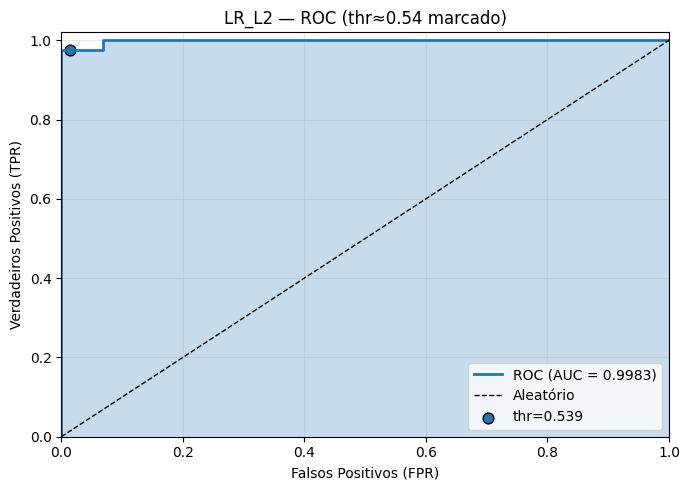

In [39]:
name = "LR_L2"
est = _get_estimator(model_packs[name])
proba_test = est.predict_proba(X_test)[:, 1]
thr_oof = float(thresholds_chosen.get(name, 0.5))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve(
    y_true=y_test, y_score=proba_test,
    title=f"{name} — ROC (thr≈{thr_oof:.2f} marcado)",
    mark_threshold=thr_oof, exact_threshold=True, ax=ax
)
plt.show()


A curva ROC fica colada ao canto superior-esquerdo e a **AUC ≈ 0,998** indica **discriminação quase perfeita** entre benigno e maligno. O ponto marcado (limiar OOF) está numa região com **TPR alto (~0,98)** e **FPR muito baixo (~1%)**, mostrando que o limiar escolhido mantém o recall elevado sem aumentar de forma relevante os falsos positivos.

**LR L2 — Curva Precision–Recall (teste) com limiar OOF marcado**

Nesta célula plotamos a **curva Precision–Recall (PR)** do modelo no **TESTE** — mais informativa que ROC em cenários com **desbalanceamento**.

* A **área sob a PR (AP)** resume o desempenho **independente de limiar**; quanto maior, melhor.
* O **ponto marcado** corresponde ao **limiar escolhido via OOF** (`thr_oof`), mostrando o par (**Recall**, **Precision**) efetivo para operação.
* As **linhas iso-F1** ajudam a visualizar o **trade-off** e em que região o ponto operacional se encontra em termos de F1.

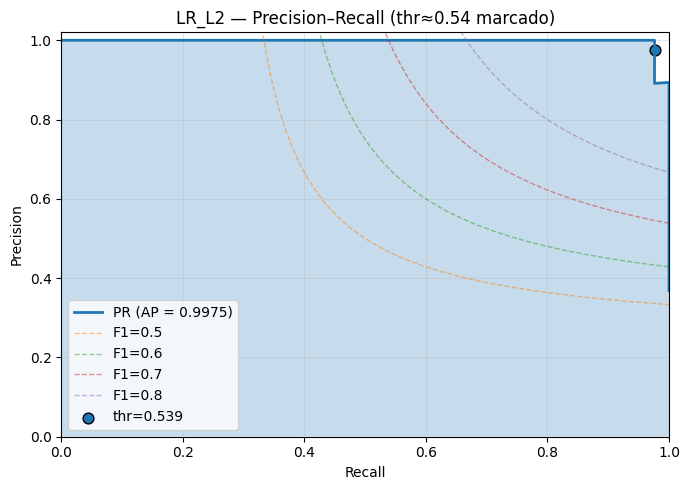

In [40]:
name = "LR_L2"
est = _get_estimator(model_packs[name])
proba_test = est.predict_proba(X_test)[:, 1]
thr_oof = float(thresholds_chosen.get(name, 0.5))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_pr_curve(
    y_true=y_test, y_score=proba_test,
    title=f"{name} — Precision–Recall (thr≈{thr_oof:.2f} marcado)",
    mark_threshold=thr_oof, show_iso_f1=True, exact_threshold=True, ax=ax
)
plt.show()


A curva PR encosta no canto superior-direito e a **AP ≈ 0,998** indica desempenho **excelente** para a classe Maligno. O ponto marcado (limiar OOF) fica numa região de **Recall alto (~0,98)** com **Precision igualmente alta (~0,98)**, acima das isolinhas **F1≥0,95**. Em resumo: o modelo mantém muitos verdadeiros positivos sem "pagar" com muitos falsos positivos.

### **XGB — matriz de confusão (teste): default 0.50 vs limiar OOF**

Comparativo do **threshold padrão (0.50)** com o **limiar OOF** (`thr_oof`) escolhido no treino.
Mostramos um **resumo numérico** (Recall/Precision/F1/ROC-AUC/AP) e **duas CMs normalizadas por classe** (linhas somam 1).
*Nota:* no XGB, o OOF pode ficar **mais conservador** e **reduzir o Recall**; o **default=0.50** costuma ser preferível aqui.


=== XGB — TESTE ===
Default@0.50 -> Recall=0.9524 | Precision=1.0000 | F1=0.9756 | AUC=0.9967 | AP=0.9954
Tuned@0.53 -> Recall=0.9286 | Precision=1.0000 | F1=0.9630 | AUC=0.9967 | AP=0.9954


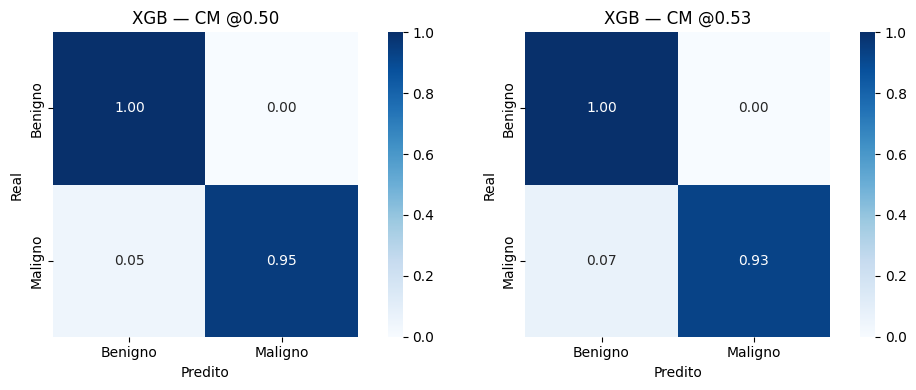

In [41]:
name = "XGB"
est = _get_estimator(model_packs[name])
proba_test = est.predict_proba(X_test)[:, 1]
thr_oof = float(thresholds_chosen.get(name, 0.5))

# Resumo numérico rápido (default vs tuned)
info_def = evaluate_at_threshold(y_test, proba_test, threshold=0.50)
info_tun = evaluate_at_threshold(y_test, proba_test, threshold=thr_oof)

print(f"=== {name} — TESTE ===")
print(f"Default@0.50 -> Recall={info_def['recall']:.4f} | Precision={info_def['precision']:.4f} | F1={info_def['f1']:.4f} | AUC={info_def['roc_auc']:.4f} | AP={info_def['ap']:.4f}")
print(f"Tuned@{thr_oof:.2f} -> Recall={info_tun['recall']:.4f} | Precision={info_tun['precision']:.4f} | F1={info_tun['f1']:.4f} | AUC={info_tun['roc_auc']:.4f} | AP={info_tun['ap']:.4f}")

fig, axs = plt.subplots(1, 2, figsize=(11, 4))
plot_confusion_matrix(
    y_true=y_test, y_score=proba_test, threshold=0.50,
    labels=("Benigno", "Maligno"),
    title=f"{name} — CM @0.50",
    ax=axs[0],
    normalize="true"
)
plot_confusion_matrix(
    y_true=y_test, y_score=proba_test, threshold=thr_oof,
    labels=("Benigno", "Maligno"),
    title=f"{name} — CM @{thr_oof:.2f}",
    ax=axs[1],
    normalize="true"
)
plt.tight_layout()
plt.show()


Com **threshold 0.50**, o XGB acerta **~100%** dos **Benignos** (FPR ≈ **0**) e **~95%** dos **Malignos** (alto *recall*). Ao elevar para **OOF ≈ 0.53**, a **taxa de verdadeiros positivos cai para ~93%** enquanto o FPR **permanece ~0%**. Ou seja, o OOF ficou **mais conservador**, **reduzindo levemente o Recall** sem ganho material em precisão (que já estava ~**1.00**). Para manter a meta de **Recall ≥ 0,95**, **prefirimos 0.50**.

### **XGB — Curva ROC (teste) com limiar OOF marcado**

Curva ROC no **teste** com **AUC** (independente de limiar).
Marcamos o ponto correspondente ao **`thr_oof`** para visualizar (**FPR**, **TPR**) no limiar adotado.
*Nota:* mantemos o **default=0.50** como referência operacional; o ponto OOF é exibido para comparação.


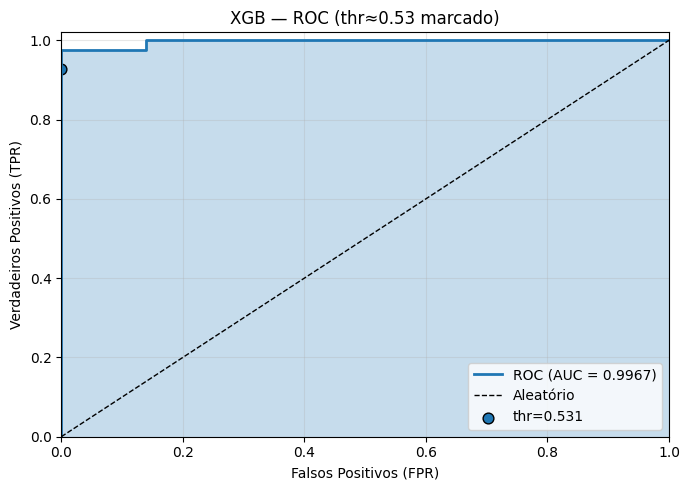

In [42]:
name = "XGB"
est = _get_estimator(model_packs[name])
proba_test = est.predict_proba(X_test)[:, 1]
thr_oof = float(thresholds_chosen.get(name, 0.5))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve(
    y_true=y_test, y_score=proba_test,
    title=f"{name} — ROC (thr≈{thr_oof:.2f} marcado)",
    mark_threshold=thr_oof, exact_threshold=True, ax=ax
)
plt.show()


A **AUC ≈ 0.9967** indica **discriminação excelente**. O ponto marcado (OOF ~0.53) está em região de **TPR ~0.93** com **FPR quase nulo**. Um limiar um pouco **mais baixo (0.50)** desloca o ponto **para cima** (maior TPR) praticamente **sem penalizar FPR**, alinhando melhor com a meta de Recall.

### **XGB — Curva Precision–Recall (teste) com limiar OOF marcado**

Curva **PR** no **teste**, com **AP** (independente de limiar) e o ponto do **`thr_oof`** destacado (**Recall**, **Precision**).
Inclui **linhas iso-F1** para facilitar a leitura do trade-off.
*Nota:* para XGB, o **default=0.50** tende a preservar o **Recall** desejado.


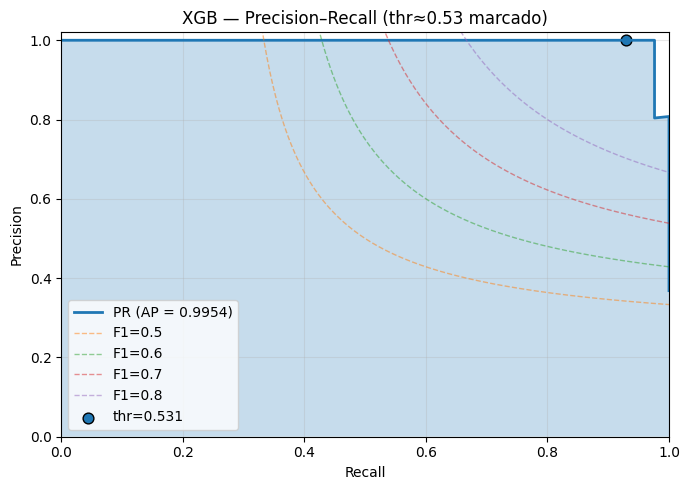

In [43]:
name = "XGB"
est = _get_estimator(model_packs[name])
proba_test = est.predict_proba(X_test)[:, 1]
thr_oof = float(thresholds_chosen.get(name, 0.5))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_pr_curve(
    y_true=y_test, y_score=proba_test,
    title=f"{name} — Precision–Recall (thr≈{thr_oof:.2f} marcado)",
    mark_threshold=thr_oof, show_iso_f1=True, exact_threshold=True, ax=ax
)
plt.show()


A **AP ≈ 0.9954** confirma **desempenho de topo** para a classe Maligno. No ponto OOF (~0.53), a **Precision permanece ~1.00** e o **Recall fica ~0.93**. A curva sugere que **em 0.50** é possível **aumentar o Recall (~0.95)** mantendo **Precision ≈ 1.00**, resultando em **F1** ligeiramente superior. Conclusão: para XGB, **operar em 0.50** é a escolha prática porque a prioridade é **Recall**.

# ✅ Análise final & escolha do modelo

**O que os gráficos confirmam (TESTE):**

* **LR_L2** (12 variáveis – *MoreStable12*):

  * **ROC-AUC ≈ 0.9983 | AP ≈ 0.9975 | Recall ≈ 0.976**.
  * CM @0.50 e @OOF≈0.54 são praticamente idênticas (≈98% de malignos capturados, ≈99% de benignos corretos).
  * Conclusão: já está **bem calibrado** em 0.50; o ajuste OOF não trouxe ganho material.

* **XGB**:

  * **ROC-AUC ≈ 0.9967 | AP ≈ 0.9954 | Recall ≈ 0.952** com **threshold 0.50** (atinge a meta).
  * Em **OOF≈0.53**, o recall cai para ≈0.93 sem benefício relevante em precisão → **mais conservador do que precisamos**.

(Referência: **RF** ficou abaixo da meta de recall; **LR_EN** mostrou **instabilidade** entre reexecuções — ambos descartados.)

**Decisão**

* **Modelo escolhido:** **Regressão Logística L2 (LR_L2)** com **threshold = 0.50**.

  * Motivos: maior **Recall** no teste (≈0.976), métricas globais **de topo**, comportamento **estável** e implementação **simples/interpretável**.
* **Plano B:** **XGB** com **threshold = 0.50** (atinge Recall ≥ 0.95, mas fica abaixo do LR_L2).


In [44]:
from pprint import pprint

est = model_packs["LR_L2"]["estimator"] if isinstance(model_packs["LR_L2"], dict) else model_packs["LR_L2"]
clf = est.named_steps["clf"]

# Apenas hiperparâmetros do classificador (sem os herdados do Pipeline)
params_clf = {k: v for k, v in clf.get_params(deep=False).items()}
pprint(params_clf)


{'C': 7.510418,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 4000,
 'multi_class': 'deprecated',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}
